# Script to Grab files from ompsql search and then reduce using ORACDR</b>

Reading in files from ompsql database search to then reduce with oracdr.

* The aim - to make this automated

* The issue - identifying the same strong lines in the USB and LSB in the signal band - whilst there may be contamination from the image sideband. 


ideas:

* need to iprove baselines some are still wavey

* need to check out scross (figaro?) - align.

* use ndftrace - 

* use fellwalker? use gaussclumps? then match so we get only lines in the signal band. 

In [1]:
from astropy.table import Table, Column, Row, vstack, unique, join

In [2]:
from matplotlib import pyplot as plt
plt.ion()
import numpy as np
import glob
import os

In [3]:
from starlink import wrapper
print(wrapper.starpath)
from starlink import kappa
from starlink import smurf
from starlink.utilities import get_ndf_fitshdr

/star


In [4]:
import logging

logging.basicConfig(level=logging.DEBUG)
logging.root.setLevel(logging.DEBUG)

# Get list of observation:

cd /export/data/hparsons/instrumentation/RxA3m/sideband-testing

run:

ompsql < omp-rxa3m-sideband-testing-2018.sql > ! out-omp-rxa3m-sideband-testing-2018.txt

which contains:

use jcmt;

select c.object, c.utdate, c.obsnum, a.lofreqe, a.obs_sb,(a.freq_sig_lower+a.freq_sig_upper)/2, (a.freq_img_lower+a.freq_img_upper)/2, bwmode, nsubband, subbands, a.doppler, a.zsource FROM COMMON as c join ACSIS as a on c.obsid=a.obsid WHERE c.project="M18AEC07" ;

run:

ompsql < omp-rxa3m-sideband-testing-2016.sql > ! out-omp-rxa3m-sideband-testing-2016.txt

which contains: 

use jcmt;

select c.object, c.utdate, c.obsnum, a.lofreqe, a.obs_sb,(a.freq_sig_lower+a.freq_sig_upper)/2, (a.freq_img_lower+a.freq_img_upper)/2, bwmode, nsubband, subbands, a.doppler, a.zsource FROM COMMON as c join ACSIS as a on  c.obsid=a.obsid WHERE c.project="JCMTCAL" and c.utdate=20161123 and (c.object="W3(OH)" or c.object="OMC1");




In [5]:
tdata2016 = Table.read('/export/data/hparsons/instrumentation/RxA3m/sideband-testing/out-omp-rxa3m-sideband-testing-2016.txt',format='ascii',header_start=0,data_start=1)
tdata2018 = Table.read('/export/data/hparsons/instrumentation/RxA3m/sideband-testing/out-omp-rxa3m-sideband-testing-2018.txt',format='ascii',header_start=0,data_start=1)

We stack the input data tables, and we rename some of the columns to make it easier to read/understand

We also remove duplicates from the table

In [6]:
data = vstack([tdata2016,tdata2018])

#data=tdata2018

data['(a.freq_sig_lower+a.freq_sig_upper)/2'].name = 'mid_signal_band'
data['(a.freq_img_lower+a.freq_img_upper)/2'].name = 'mid_image_band'


tdata = unique(data, keys=['utdate','obsnum','lofreqe'], keep='last')

tdata.show_in_notebook()

idx,object,utdate,obsnum,lofreqe,obs_sb,mid_signal_band,mid_image_band,bwmode,nsubband,subbands,doppler,zsource
0,W3(OH),20161123,25,234.5747148054,LSB,230.12574679861353,239.02570866265646,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057
1,W3(OH),20161123,26,226.5747117108,USB,231.02567357211322,222.12571276954034,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057
2,W3(OH),20161123,27,233.7745811638,LSB,229.32561594817832,238.22557802655996,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057
3,W3(OH),20161123,28,235.3748328419,LSB,230.9258776724552,239.82583983977707,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057
4,W3(OH),20161123,29,225.774574946,USB,230.2255426983488,221.32558160157035,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057
5,W3(OH),20161123,30,227.3748265853,USB,231.825804413345,222.92584321053528,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057
6,W3(OH),20161123,31,222.2569217405,LSB,217.80791827088026,226.7078806782371,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057
7,W3(OH),20161123,32,221.4567914589,LSB,217.00778741576198,225.90774993455622,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057
8,W3(OH),20161123,33,223.0570431222,LSB,218.6080491401517,227.5080117511588,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057
9,W3(OH),20161123,36,223.5952945756,LSB,219.14630797912065,228.04627078622667,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057


In [7]:
print (tdata.colnames)
#print(tdata.dtype)

['object', 'utdate', 'obsnum', 'lofreqe', 'obs_sb', 'mid_signal_band', 'mid_image_band', 'bwmode', 'nsubband', 'subbands', 'doppler', 'zsource']


# Check for (and produce if needed) Reduced data files:


## Reduce files using ORACDR

see https://github.com/eaobservatory/Tutorials/blob/master/starlink-pywrapper%20Example.ipynb for more details

For this we loop over the table length dates create known file names check if they exist, store names if they exist. Reduce data if needed

Before any reductions are made we firt grab all desired information about the onbservation from the fits header.

In [8]:
reducedfiles = []
reducedpaths = []

jcmtmedtsys = []
jcmttaust = []
jcmttauen = []
jcmtelstart = []
jcmtelend = []
jcmtamstart = []
jcmtamend = []

finalfrqsig = []
finalfrqimg = []

for x in range(len(tdata['utdate'])):
    ut = str(tdata['utdate'][x])
    obsnum = str(tdata['obsnum'][x])
    padobsnum = str(obsnum.zfill(5))
    rawpath = ('/jcmtdata/raw/acsis/spectra/'+ut+'/'+padobsnum+'/')
    rawname = ('a'+ut+'_'+padobsnum+'*.sdf')
    
    
    fitsheader = get_ndf_fitshdr(rawpath+'a'+ut+'_'+padobsnum+'_01_0001.sdf')
    jcmtmedtsys.append(fitsheader['MEDTSYS'])
    jcmttaust.append(fitsheader['WVMTAUST'])
    jcmttauen.append(fitsheader['WVMTAUEN'])
    jcmtelstart.append(fitsheader['ELSTART'])
    jcmtelend.append(fitsheader['ELEND'])
    jcmtamstart.append(fitsheader['AMSTART'])
    jcmtamend.append(fitsheader['AMEND'])
    
    import glob
    rawfiles = glob.glob(rawpath+rawname) # glob is similar to ls but runs on disk    
    outdirectory = '/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/'
    
    testreduced = (outdirectory+'ORAC*/ga'+ut+'_'+obsnum+'_*'+'_reduced001.sdf')

    print (str(x)+' searching for '+testreduced)
    
    if (glob.glob(testreduced)):
        reduced = str(glob.glob(testreduced)).strip('[\'\']')
        reducedpath = os.path.split(reduced)[0]
        reducedfile = os.path.split(reduced)[1]
        print ('\n'+str(x)+' file exists - '+reducedfile+' - continue processing\n')
        reducedfiles.append(reducedfile)
        reducedpaths.append(reducedpath)


    if not (glob.glob(testreduced)):
        print ('\n'+str(x)+' file does not exist - reducing: '+str(rawfiles)+' please be patient...\n')
        output = wrapper.oracdr('acsis', loop='file', dataout=outdirectory, 
                                recipe='REDUCE_SCIENCE_NARROWLINE', rawfiles=rawfiles)
        reduced = str(glob.glob(testreduced)).strip('[\'\']')
        reducedpath = os.path.split(reduced)[0]
        reducedfile = os.path.split(reduced)[1]
        print ('\n'+str(x)+' file produced - '+reducedfile+' - continue processing\n')
        reducedfiles.append(reducedfile)
        reducedpaths.append(reducedpath)

    if len(reducedfile)>1:
        fitsheader = get_ndf_fitshdr(reduced)
        jcmtfrqsiglo = fitsheader['FRQSIGLO']
        jcmtfrqsighi = fitsheader['FRQSIGHI']
        jcmtfrqimglo = fitsheader['FRQIMGLO']
        jcmtfrqimghi = fitsheader['FRQIMGHI']
        finalfrqsig.append(str.format('{0:.3f}',((jcmtfrqsiglo+jcmtfrqsighi)/2)))
        finalfrqimg.append(str.format('{0:.3f}',((jcmtfrqimglo+jcmtfrqimghi)/2)))
    else:
        finalfrqsig.append(np.nan)
        finalfrqimg.append(np.nan)
        
jcmtmedtsys = Column(jcmtmedtsys, name='jcmtmedtsys')
jcmttaust = Column(jcmttaust, name='jcmttaust')
jcmttauen = Column(jcmttauen, name='jcmttauen')
jcmtelstart = Column(jcmtelstart, name='jcmtelstart')
jcmtelend = Column(jcmtelend, name='jcmtelend')
jcmtamstart = Column(jcmtamstart, name='jcmtamstart')
jcmtamend = Column(jcmtamend, name='jcmtamend')

finalfrqsig = Column(finalfrqsig, name='finalfrqsig')
finalfrqimg = Column(finalfrqimg, name='finalfrqimg')

reducedfiles = Column(reducedfiles, name='reducedfiles')
reducedpaths = Column(reducedpaths, name='reducedpaths')


0 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_25_*_reduced001.sdf

0 file exists - ga20161123_25_1_reduced001.sdf - continue processing

1 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_26_*_reduced001.sdf

1 file exists - ga20161123_26_1_reduced001.sdf - continue processing

2 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_27_*_reduced001.sdf

2 file exists - ga20161123_27_1_reduced001.sdf - continue processing

3 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_28_*_reduced001.sdf

3 file exists - ga20161123_28_1_reduced001.sdf - continue processing

4 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_29_*_reduced001.sdf

4 file exists - ga20161123_29_1_reduced001.sdf - continue processing

5 searching for /export/data/hparso


44 file exists - ga20161123_82_1_reduced001.sdf - continue processing

45 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_83_*_reduced001.sdf

45 file exists - ga20161123_83_1_reduced001.sdf - continue processing

46 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_84_*_reduced001.sdf

46 file exists - ga20161123_84_1_reduced001.sdf - continue processing

47 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_85_*_reduced001.sdf

47 file exists - ga20161123_85_1_reduced001.sdf - continue processing

48 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_86_*_reduced001.sdf

48 file exists - ga20161123_86_1_reduced001.sdf - continue processing

49 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_87_*_reduced001.sdf

49 file exists - ga20161

87 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_139_*_reduced001.sdf

87 file exists - ga20161123_139_1_reduced001.sdf - continue processing

88 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_140_*_reduced001.sdf

88 file exists - ga20161123_140_1_reduced001.sdf - continue processing

89 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_141_*_reduced001.sdf

89 file exists - ga20161123_141_1_reduced001.sdf - continue processing

90 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_142_*_reduced001.sdf


DEBUG:starlink.wrapper:Working output directory for ORAC-DR is /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinghq76usjn.
INFO:starlink.wrapper:Keyword Argument datain was not given, so defaulting to .
DEBUG:starlink.wrapper:Setting $INSTRUMENT to ACSIS.
INFO:starlink.wrapper:Setting ORAC_DATA_IN to .
DEBUG:starlink.wrapper:Using temporary list of raw observations in /tmp/tmpORACInputList.lisfhqoej3u.
INFO:starlink.wrapper:Running /star/Perl/bin/perl /star/bin/oracdr/src/bin/oracdr -log=sf -nodisplay -batch -loop=file -files=/tmp/tmpORACInputList.lisfhqoej3u REDUCE_SCIENCE_NARROWLINE.



90 file exists - ga20161123_142_1_reduced001.sdf - continue processing

91 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_143_*_reduced001.sdf

91 file does not exist - reducing: ['/jcmtdata/raw/acsis/spectra/20161123/00143/a20161123_00143_01_0001.sdf', '/jcmtdata/raw/acsis/spectra/20161123/00143/a20161123_00143_02_0001.sdf'] please be patient...



ERROR:starlink.wrapper:ORAC-DR ended with an error! You may or may not care about this.



91 file produced -  - continue processing

92 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_144_*_reduced001.sdf

92 file exists - ga20161123_144_1_reduced001.sdf - continue processing

93 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_145_*_reduced001.sdf

93 file exists - ga20161123_145_1_reduced001.sdf - continue processing

94 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_146_*_reduced001.sdf

94 file exists - ga20161123_146_1_reduced001.sdf - continue processing

95 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_147_*_reduced001.sdf

95 file exists - ga20161123_147_1_reduced001.sdf - continue processing

96 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20161123_148_*_reduced001.sdf

96 file exists - ga20161123_148_1_reduced00

134 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20180402_71_*_reduced001.sdf

134 file exists - ga20180402_71_1_reduced001.sdf - continue processing

135 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20180402_72_*_reduced001.sdf

135 file exists - ga20180402_72_1_reduced001.sdf - continue processing

136 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20180402_73_*_reduced001.sdf

136 file exists - ga20180402_73_1_reduced001.sdf - continue processing

137 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20180402_74_*_reduced001.sdf

137 file exists - ga20180402_74_1_reduced001.sdf - continue processing

138 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20180402_76_*_reduced001.sdf

138 file exists - ga20180402_76_1_reduced001.sdf - continue processing

139 searching f


178 file exists - ga20180418_76_1_reduced001.sdf - continue processing

179 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20180418_77_*_reduced001.sdf

179 file exists - ga20180418_77_1_reduced001.sdf - continue processing

180 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20180418_78_*_reduced001.sdf

180 file exists - ga20180418_78_1_reduced001.sdf - continue processing

181 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20180418_79_*_reduced001.sdf

181 file exists - ga20180418_79_1_reduced001.sdf - continue processing

182 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20180418_80_*_reduced001.sdf

182 file exists - ga20180418_80_1_reduced001.sdf - continue processing

183 searching for /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORAC*/ga20180418_81_*_reduced001.sdf

183 file exist

Notes from Sarah:

output.datafiles # files produced by ORAC

output.imagefiles # anything ended in png

output.outdir

output.runlog


print([i for i in output.datafiles if os.path.split(i)[1].startswith('g') and 'reduced' in os.path.split(i)[1]])




# Add reduced filenames and fitsheader info to table (if needed)

In [9]:

try:
    if tdata['jcmtmedtsys'].any:
        print ('column exists')
except:
    print ('column does not exist')
    tdata.add_columns([jcmtmedtsys])
    print ('added tdata[jcmtmedtsys]')

try:
    if tdata['jcmttaust'].any:
        print ('column exists')
except:
    print ('column does not exist')
    tdata.add_columns([jcmttaust])
    print ('added tdata[jcmttaust]')

try:
    if tdata['jcmttauen'].any:
        print ('column exists')
except:
    print ('column does not exist')
    tdata.add_columns([jcmttauen])
    print ('added tdata[jcmttauen]')

try:
    if tdata['jcmtelstart'].any:
        print ('column exists')
except:
    print ('column does not exist')
    tdata.add_columns([jcmtelstart])
    print ('added tdata[jcmtelstart]')

try:
    if tdata['jcmtelend'].any:
        print ('column exists')
except:
    print ('column does not exist')
    tdata.add_columns([jcmtelend])
    print ('added tdata[jcmtelend]')

try:
    if tdata['jcmtamstart'].any:
        print ('column exists')
except:
    print ('column does not exist')
    tdata.add_columns([jcmtamstart])
    print ('added tdata[jcmtamstart]')

try:
    if tdata['jcmtamend'].any:
        print ('column exists')
except:
    print ('column does not exist')
    tdata.add_columns([jcmtamend])
    print ('added tdata[jcmtamend]')

try:
    if tdata['finalfrqsig'].any:
        print ('column exists')
except:
    print ('column does not exist')
    tdata.add_columns([finalfrqsig])
    print ('added tdata[finalfrqsig]')

try:
    if tdata['finalfrqimg'].any:
        print ('column exists')
except:
    print ('column does not exist')
    tdata.add_columns([finalfrqimg])
    print ('added tdata[finalfrqimg]')

try:
    if tdata['reducedpaths'].any:
        print ('column exists')
except:
    print ('column does not exist')
    tdata.add_columns([reducedpaths])
    print ('added tdata[reducedpaths]')

try:
    if tdata['reducedfiles'].any:
        print ('column exists')
except:
    print ('column does not exist')
    tdata.add_columns([reducedfiles])
    print ('added tdata[reducedfiles]')

column does not exist
added tdata[jcmtmedtsys]
column does not exist
added tdata[jcmttaust]
column does not exist
added tdata[jcmttauen]
column does not exist
added tdata[jcmtelstart]
column does not exist
added tdata[jcmtelend]
column does not exist
added tdata[jcmtamstart]
column does not exist
added tdata[jcmtamend]
column does not exist
added tdata[finalfrqsig]
column does not exist
added tdata[finalfrqimg]
column does not exist
added tdata[reducedpaths]
column does not exist
added tdata[reducedfiles]


In [10]:
tdata.show_in_notebook()

idx,object,utdate,obsnum,lofreqe,obs_sb,mid_signal_band,mid_image_band,bwmode,nsubband,subbands,doppler,zsource,jcmtmedtsys,jcmttaust,jcmttauen,jcmtelstart,jcmtelend,jcmtamstart,jcmtamend,finalfrqsig,finalfrqimg,reducedpaths,reducedfiles
0,W3(OH),20161123,25,234.5747148054,LSB,230.12574679861353,239.02570866265646,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,556.067565918,0.1916653364897,0.1978798210621,46.36191020669,46.41781021348,1.382068577308,1.380820993668,230.576,238.576,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingbw1wb1wd,ga20161123_25_1_reduced001.sdf
1,W3(OH),20161123,26,226.5747117108,USB,231.02567357211322,222.12571276954034,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,512.1989746094,0.1973477452993,0.1997934132814,46.52040946207,46.57278083124,1.378436512232,1.377027416689,230.576,222.576,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingcr35zkw6,ga20161123_26_1_reduced001.sdf
2,W3(OH),20161123,27,233.7745811638,LSB,229.32561594817832,238.22557802655996,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,581.2537841797,0.1997650712729,0.2021773010492,46.67196031867,46.72274235413,1.374991819111,1.373748497626,229.776,237.776,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking95w810mu,ga20161123_27_1_reduced001.sdf
3,W3(OH),20161123,28,235.3748328419,LSB,230.9258776724552,239.82583983977707,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,597.9815063477,0.203297495842,0.2029528021812,46.81259914086,46.85922624619,1.371816067495,1.370550405828,231.376,239.376,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingtaokfasy,ga20161123_28_1_reduced001.sdf
4,W3(OH),20161123,29,225.774574946,USB,230.2255426983488,221.32558160157035,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,487.6442565918,0.2026681602001,0.2031205296516,46.94769141632,46.99132360117,1.368789960596,1.367623418136,229.776,221.776,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingvaqk9ob1,ga20161123_29_1_reduced001.sdf
5,W3(OH),20161123,30,227.3748265853,USB,231.825804413345,222.92584321053528,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,538.6174316406,0.2033258527517,0.2037589550018,47.06988708316,47.1111949246,1.366066473424,1.364994281406,231.376,223.376,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingsqqx683u,ga20161123_30_1_reduced001.sdf
6,W3(OH),20161123,31,222.2569217405,LSB,217.80791827088026,226.7078806782371,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,515.8450317383,0.203587397933,0.2020822763443,47.186192009,47.22298853674,1.363494246457,1.362518683198,218.258,226.258,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingju1ap_4e,ga20161123_31_1_reduced001.sdf
7,W3(OH),20161123,32,221.4567914589,LSB,217.00778741576198,225.90774993455622,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,487.8038024902,0.200617864728,0.2003332227468,47.29204561714,47.32691752908,1.361163652305,1.360233413581,217.458,225.458,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking5nbneawr,ga20161123_32_1_reduced001.sdf
8,W3(OH),20161123,33,223.0570431222,LSB,218.6080491401517,227.5080117511588,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,511.1616210938,0.2001552283764,0.1992850005627,47.39117756797,47.42256521051,1.358993850224,1.3581826786,219.058,227.058,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking_gnsxytg,ga20161123_33_1_reduced001.sdf
9,W3(OH),20161123,36,223.5952945756,LSB,219.14630797912065,228.04627078622667,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,516.8359375,0.1982269585133,0.1966703385115,47.53503623121,47.56220004223,1.355866048616,1.355232751194,219.596,227.596,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingqidz_cs8,ga20161123_36_1_reduced001.sdf


# Fitting data with fit1d

In this we need to

grab the name of the reduced file

use KAPPA stats to get the rms from each reduced file

then use smurf fit1d to fit to the data (if can) - and sotre to a sesible location/name

then use kappa stats on the fit 

record the result in our table

Right now the range over which we fit is specified in:

/export/data/hparsons/instrumentation/RxA3m/sideband-testing/fit1d_config.lis

which contains: 

AXIS = 3

RANGE = (-200,200)

This will not be appropriate to all situations

In [11]:
config_fit1d = '/export/data/hparsons/instrumentation/RxA3m/sideband-testing/fit1d_config.lis'

errors = []
fit1dpeaks = []
fit1dfiles = []
snr = []

for x in range(len(tdata['utdate'])):
    ut = str(tdata['utdate'][x])
    obsnum = str(tdata['obsnum'][x])
    reducedpath = str(tdata['reducedpaths'][x])
    reducedfile = str(tdata['reducedfiles'][x])
    fit1dfilename = reducedfile.strip('.sdf')+'_fit1d.sdf'
    
    print ('\n'+str(x))

    print(ut, obsnum, reducedpath, reducedfile, fit1dfilename)   
    


    if len(tdata['reducedfiles'][x])>1:
        print ('reduced file exists:'+tdata['reducedfiles'][x]+':')
            
        file = (str(reducedpath)+'/'+str(reducedfile))
        filefit1d = (str(reducedpath)+'/'+fit1dfilename)

    
        statsvals_error = kappa.stats(file, order=True, comp='ERROR')
        error = statsvals_error.median
        
        if not (glob.glob(filefit1d)):
            fit1dprocess = smurf.fit1d(in_=file, out=filefit1d,rms=error,config='^'+config_fit1d)
    
        statsvals_fit1d = kappa.stats(filefit1d, order=True, comp='DATA')
        peak = statsvals_fit1d.maximum
        snrvalue = peak/error
        
        
        if (snrvalue>3):
            fit1dfiles.append(fit1dfilename) 
            errors.append(error)
            fit1dpeaks.append(peak)
            snr.append(snrvalue)
        else:
            fit1dfiles.append(np.nan) 
            errors.append(np.nan)
            fit1dpeaks.append(np.nan)
            snr.append(np.nan)
    
        print (error)    
        print (peak)
        print (snrvalue)
    
    else:
        print ('reduced file does not exist')
        errors.append(np.nan)
        fit1dpeaks.append(np.nan)
        fit1dfiles.append(np.nan)
        snr.append(np.nan)
        


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingbw1wb1wd/ga20161123_25_1_reduced001.sdf', 'order=True', 'comp=ERROR']
DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingbw1wb1wd/ga20161123_25_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 597.778
         Pixel mean             : 0.158184
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.158184
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 1154.461)
         Maximum pixel value    : 0.158184
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 1154.461)
         Pixe


0
20161123 25 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingbw1wb1wd ga20161123_25_1_reduced001.sdf ga20161123_25_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_25_1_reduced001.sdf:
0.15818406641483307
15.846259117126465
100.17607636644082

1
20161123 26 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingcr35zkw6 ga20161123_26_1_reduced001.sdf ga20161123_26_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_26_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingcr35zkw6/ga20161123_26_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 547.302
         Pixel mean             : 0.144827
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.144827
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1244.461)
         Maximum pixel value    : 0.144827
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1244.461)
         Pixel median           : 0.144827
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrum

0.1448272317647934
15.541788101196289
107.31260904328354

2
20161123 27 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking95w810mu ga20161123_27_1_reduced001.sdf ga20161123_27_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_27_1_reduced001.sdf:
0.16036197543144226
1.4347286224365234
8.946813099405206

3
20161123 28 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingtaokfasy ga20161123_28_1_reduced001.sdf ga20161123_28_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_28_1_reduced001.sdf:
0.16540957987308502
-1.7976931348623157e+308
-inf

4
20161123 29 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingvaqk9ob1 ga20161123_29_1_reduced001.sdf ga20161123_29_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_29_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingvaqk9ob1/ga20161123_29_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 532.23
         Pixel mean             : 0.140839
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.140839
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1248.638)
         Maximum pixel value    : 0.140839
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1248.638)
         Pixel median           : 0.140839
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrume

0.1408388763666153
0.6656971573829651
4.726657685411378

5
20161123 30 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingsqqx683u ga20161123_30_1_reduced001.sdf ga20161123_30_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_30_1_reduced001.sdf:
0.15130996704101562
1.265869140625
8.36606580108408

6
20161123 31 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingju1ap_4e ga20161123_31_1_reduced001.sdf ga20161123_31_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_31_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingju1ap_4e/ga20161123_31_1_reduced001_fit1d

      Title                     : Fitted profiles
      NDF array analysed        : DATA

         Pixel sum              : 20.6257
         Pixel mean             : 0.00545797
         Standard deviation     : 0.0918949
         Skewness               : 19.1756
         Kurtosis               : 387.195
         Minimum pixel value    : 0
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 1222.155)
         Maximum pixel value    : 2.1577
            At pixel            : (1, 1, 2)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -47.01242)
         Pixel median           : 0
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparso

0.14521895349025726
2.1577036380767822
14.85827838734248

7
20161123 32 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking5nbneawr ga20161123_32_1_reduced001.sdf ga20161123_32_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_32_1_reduced001.sdf:
0.14053122699260712
1.1969633102416992
8.517418767749517

8
20161123 33 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking_gnsxytg ga20161123_33_1_reduced001.sdf ga20161123_33_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_33_1_reduced001.sdf:


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingqidz_cs8/ga20161123_36_1_reduced001.sdf', 'order=True', 'comp=ERROR']
DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingqidz_cs8/ga20161123_36_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 549.822
         Pixel mean             : 0.145494
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.145494
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 1214.432)
         Maximum pixel value    : 0.145494
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 1214.432)
         Pixe

0.14243127405643463
1.5935205221176147
11.18799598384709

9
20161123 36 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingqidz_cs8 ga20161123_36_1_reduced001.sdf ga20161123_36_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_36_1_reduced001.sdf:
0.1454939842224121
3.7683448791503906
25.900348384094283

10
20161123 37 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingbnaa7ugu ga20161123_37_1_reduced001.sdf ga20161123_37_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_37_1_reduced001.sdf:
0.13014692068099976
3.9267029762268066
30.171309130328652

11
20161123 38 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingk501q142 ga20161123_38_1_reduced001.sdf ga20161123_38_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_38_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingk501q142/ga20161123_38_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 532.723
         Pixel mean             : 0.140969
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.140969
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 1219.038)
         Maximum pixel value    : 0.140969
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 1219.038)
         Pixel median           : 0.140969
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumen

0.140969380736351
1.751545786857605
12.425008733871406

12
20161123 42 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkings7wypvka ga20161123_42_1_reduced001.sdf ga20161123_42_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_42_1_reduced001.sdf:
0.136254221200943
10.55785083770752
77.48641285863113

13
20161123 43 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingvk726v39 ga20161123_43_1_reduced001.sdf ga20161123_43_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_43_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingvk726v39/ga20161123_43_1_reduced001_fit1d

      Title                     : Fitted profiles
      NDF array analysed        : DATA

         Pixel sum              : 113.901
         Pixel mean             : 0.0301404
         Standard deviation     : 0.504733
         Skewness               : 19.3661
         Kurtosis               : 397.458
         Minimum pixel value    : 0
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1299.859)
         Maximum pixel value    : 12.0962
            At pixel            : (1, 1, -84)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -100.1368)
         Pixel median           : 0
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hpar

0.12423739582300186
12.096192359924316
97.36353760310206

14
20161123 44 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingmrw9ktkk ga20161123_44_1_reduced001.sdf ga20161123_44_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_44_1_reduced001.sdf:
0.133804053068161
11.179322242736816
83.54995223531807

15
20161123 45 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingqjityk9k ga20161123_45_1_reduced001.sdf ga20161123_45_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_45_1_reduced001.sdf:


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingk0xs8w35/ga20161123_46_1_reduced001.sdf', 'order=True', 'comp=ERROR']
DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingk0xs8w35/ga20161123_46_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 547.064
         Pixel mean             : 0.144764
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.144764
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 1214.212)
         Maximum pixel value    : 0.144764
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 1214.212)
         Pixe

0.12845392525196075
12.292625427246094
95.69676756186519

16
20161123 46 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingk0xs8w35 ga20161123_46_1_reduced001.sdf ga20161123_46_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_46_1_reduced001.sdf:
0.14476428925991058
3.5470080375671387
24.501954561451416

17
20161123 47 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingg9n_u330 ga20161123_47_1_reduced001.sdf ga20161123_47_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_47_1_reduced001.sdf:
0.13177935779094696
3.7759931087493896
28.653904314358364

18
20161123 48 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking6kv6u_w0 ga20161123_48_1_reduced001.sdf ga20161123_48_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_48_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking6kv6u_w0/ga20161123_48_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 512.633
         Pixel mean             : 0.135653
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.135653
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 1205.104)
         Maximum pixel value    : 0.135653
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 1205.104)
         Pixel median           : 0.135653
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumen

0.13565321266651154
-1.7976931348623157e+308
-inf

19
20161123 49 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking4mm_2t1m ga20161123_49_1_reduced001.sdf ga20161123_49_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_49_1_reduced001.sdf:
0.13228654861450195
1.0028460025787354
7.580861494097504

20
20161123 50 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingd9hlbtzw ga20161123_50_1_reduced001.sdf ga20161123_50_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_50_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingd9hlbtzw/ga20161123_50_1_reduced001_fit1d

      Title                     : Fitted profiles
      NDF array analysed        : DATA

         Pixel sum              : 16.2412
         Pixel mean             : 0.00429775
         Standard deviation     : 0.0840807
         Skewness               : 23.3347
         Kurtosis               : 581.882
         Minimum pixel value    : 0
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 1098.635)
         Maximum pixel value    : 2.42853
            At pixel            : (1, 1, 2)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -46.81626)
         Pixel median           : 0
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hpars

0.24722842872142792
2.4285311698913574
9.823025541402354

21
20161123 51 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingsqwyhvsc ga20161123_51_1_reduced001.sdf ga20161123_51_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_51_1_reduced001.sdf:
0.1660645455121994
1.4385199546813965
8.662414666806288

22
20161123 52 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking_yq7_qe9 ga20161123_52_1_reduced001.sdf ga20161123_52_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_52_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking_yq7_qe9/ga20161123_52_1_reduced001_fit1d

      Title                     : Fitted profiles
      NDF array analysed        : DATA

         Pixel sum              : 0
         Total number of pixels : 3779
         Number of pixels used  : 0 (0.0%)
         No. of pixels excluded : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking95xg0l5u/ga20161123_53_1_reduced001.sdf', 'order=True', 'comp=ERROR']
DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking95xg0l5u/ga20161123_53_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 614.862
         Pixel mean             : 0.16270

0.2351178079843521
-1.7976931348623157e+308
-inf

23
20161123 53 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking95xg0l5u ga20161123_53_1_reduced001.sdf ga20161123_53_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_53_1_reduced001.sdf:
0.1627049297094345
1.781542420387268
10.949529455369444

24
20161123 54 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingvu0yybgd ga20161123_54_1_reduced001.sdf ga20161123_54_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_54_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingvu0yybgd/ga20161123_54_1_reduced001_fit1d

      Title                     : Fitted profiles
      NDF array analysed        : DATA

         Pixel sum              : 0
         Total number of pixels : 3779
         Number of pixels used  : 0 (0.0%)
         No. of pixels excluded : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingpzj9p9jl/ga20161123_59_1_reduced001.sdf', 'order=True', 'comp=ERROR']
DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingpzj9p9jl/ga20161123_59_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 632.647
         Pixel mean             : 0.16741

0.2373645305633545
-1.7976931348623157e+308
-inf

25
20161123 59 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingpzj9p9jl ga20161123_59_1_reduced001.sdf ga20161123_59_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_59_1_reduced001.sdf:
0.16741125285625458
1.0366053581237793
6.191969419247143

26
20161123 60 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingxplopuqx ga20161123_60_1_reduced001.sdf ga20161123_60_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_60_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingxplopuqx/ga20161123_60_1_reduced001_fit1d

      Title                     : Fitted profiles
      NDF array analysed        : DATA

         Pixel sum              : 71.5987
         Pixel mean             : 0.0189465
         Standard deviation     : 0.288345
         Skewness               : 16.8107
         Kurtosis               : 294.321
         Minimum pixel value    : 0
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 1083.955)
         Maximum pixel value    : 5.80892
            At pixel            : (1, 1, 3)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -47.39059)
         Pixel median           : 0
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparson

0.2327149212360382
5.808924198150635
24.96154594341098

27
20161123 61 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinggl81ujj8 ga20161123_61_1_reduced001.sdf ga20161123_61_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_61_1_reduced001.sdf:
0.17577315866947174
5.176162242889404
29.44796738063284

28
20161123 62 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingpr02l_vk ga20161123_62_1_reduced001.sdf ga20161123_62_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_62_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingpr02l_vk/ga20161123_62_1_reduced001_fit1d

      Title                     : Fitted profiles
      NDF array analysed        : DATA

         Pixel sum              : 12.5149
         Pixel mean             : 0.0033117
         Standard deviation     : 0.0603783
         Skewness               : 23.0101
         Kurtosis               : 578.899
         Minimum pixel value    : 0
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 1087.654)
         Maximum pixel value    : 1.79599
            At pixel            : (1, 1, -449)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 223.6231)
         Pixel median           : 0
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hpar

0.23220889270305634
1.7959922552108765
7.734381893408157

29
20161123 63 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingnk_jvis8 ga20161123_63_1_reduced001.sdf ga20161123_63_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_63_1_reduced001.sdf:
0.1683179885149002
1.6585174798965454
9.853477305247898

30
20161123 64 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking90fvb3or ga20161123_64_1_reduced001.sdf ga20161123_64_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_64_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking90fvb3or/ga20161123_64_1_reduced001_fit1d

      Title                     : Fitted profiles
      NDF array analysed        : DATA

         Pixel sum              : 0
         Total number of pixels : 3779
         Number of pixels used  : 0 (0.0%)
         No. of pixels excluded : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking8hgmhlhg/ga20161123_65_1_reduced001.sdf', 'order=True', 'comp=ERROR']
DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking8hgmhlhg/ga20161123_65_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 750.106
         Pixel mean             : 0.19849

0.25185784697532654
-1.7976931348623157e+308
-inf

31
20161123 65 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking8hgmhlhg ga20161123_65_1_reduced001.sdf ga20161123_65_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_65_1_reduced001.sdf:
0.19849327206611633
0.8106479644775391
4.084007261503148

32
20161123 66 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingscxz5oxb ga20161123_66_1_reduced001.sdf ga20161123_66_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_66_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingscxz5oxb/ga20161123_66_1_reduced001_fit1d

      Title                     : Fitted profiles
      NDF array analysed        : DATA

         Pixel sum              : 0
         Total number of pixels : 3779
         Number of pixels used  : 0 (0.0%)
         No. of pixels excluded : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking922dv5z7/ga20161123_67_1_reduced001.sdf', 'order=True', 'comp=ERROR']
DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking922dv5z7/ga20161123_67_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 1160.47
         Pixel mean             : 0.30708

0.48249420523643494
-1.7976931348623157e+308
-inf

33
20161123 67 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking922dv5z7 ga20161123_67_1_reduced001.sdf ga20161123_67_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_67_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking922dv5z7/ga20161123_67_1_reduced001_fit1d

      Title                     : Fitted profiles
      NDF array analysed        : DATA

         Pixel sum              : 8.98656
         Pixel mean             : 0.00237803
         Standard deviation     : 0.0488235
         Skewness               : 26.5342
         Kurtosis               : 779.416
         Minimum pixel value    : 0
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1107.499)
         Maximum pixel value    : 1.69389
            At pixel            : (1, 1, -341)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -236.2386)
         Pixel median           : 0
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/h

0.3070831894874573
1.6938881874084473
5.516056382753031

34
20161123 68 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingdrejy80y ga20161123_68_1_reduced001.sdf ga20161123_68_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_68_1_reduced001.sdf:
0.46157151460647583
8.456672668457031
18.321478689314215

35
20161123 69 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking011d66fd ga20161123_69_1_reduced001.sdf ga20161123_69_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_69_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking011d66fd/ga20161123_69_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 1163.03
         Pixel mean             : 0.307761
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.307761
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1110.775)
         Maximum pixel value    : 0.307761
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1110.775)
         Pixel median           : 0.307761
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrum

0.3077605366706848
1.2433055639266968
4.03984727014263

36
20161123 70 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingps5mxed5 ga20161123_70_1_reduced001.sdf ga20161123_70_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_70_1_reduced001.sdf:
0.5004030466079712
-1.7976931348623157e+308
-inf

37
20161123 71 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingvkjks2aj ga20161123_71_1_reduced001.sdf ga20161123_71_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_71_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingvkjks2aj/ga20161123_71_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 1243.39
         Pixel mean             : 0.329025
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.329025
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1104.243)
         Maximum pixel value    : 0.329025
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1104.243)
         Pixel median           : 0.329025
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrum

0.3290252089500427
0.9889334440231323
3.005646428062253

38
20161123 72 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingkabmqft3 ga20161123_72_1_reduced001.sdf ga20161123_72_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_72_1_reduced001.sdf:
0.786045491695404
6.13960599899292
7.810751494484804

39
20161123 73 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingw_sj37i7 ga20161123_73_1_reduced001.sdf ga20161123_73_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_73_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingw_sj37i7/ga20161123_73_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 261054
         Pixel mean             : 73.3298
         Standard deviation     : 39.6362
         Skewness               : 3.29237
         Kurtosis               : 13.653
         Minimum pixel value    : 41.9857
            At pixel            : (1, 1, -1192)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -700.711)
         Maximum pixel value    : 299.838
            At pixel            : (1, 1, 987)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 498.9483)
         Pixel median           : 58.8031
         Total number of pixels : 3779
         Number of pixels used  : 3560 (94.2%)
         No. of pixels excluded : 219 (5.8%)


DEBUG:starlink.wrapper:['/s

58.80308151245117
-1.7976931348623157e+308
-3.0571410351712026e+306

40
20161123 75 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinghzf4q2e9 ga20161123_75_1_reduced001.sdf ga20161123_75_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_75_1_reduced001.sdf:
0.5176859498023987
-1.7976931348623157e+308
-inf

41
20161123 79 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingpfx1n5bf ga20161123_79_1_reduced001.sdf ga20161123_79_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_79_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingpfx1n5bf/ga20161123_79_1_reduced001_fit1d

      Title                     : Fitted profiles
      NDF array analysed        : DATA

         Pixel sum              : 0
         Total number of pixels : 3779
         Number of pixels used  : 0 (0.0%)
         No. of pixels excluded : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingwousj9f3/ga20161123_80_1_reduced001.sdf', 'order=True', 'comp=ERROR']
DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingwousj9f3/ga20161123_80_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 3267.75
         Pixel mean             : 0.86471

63.15212631225586
-1.7976931348623157e+308
-2.846607453838715e+306

42
20161123 80 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingwousj9f3 ga20161123_80_1_reduced001.sdf ga20161123_80_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_80_1_reduced001.sdf:
0.8637624979019165
39.957523345947266
46.259849719111784

43
20161123 81 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingey7xdu1f ga20161123_81_1_reduced001.sdf ga20161123_81_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_81_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingey7xdu1f/ga20161123_81_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 4749.44
         Pixel mean             : 1.2568
         Standard deviation     : 0.00252541
         Skewness               : 10.9181
         Kurtosis               : 150.143
         Minimum pixel value    : 1.25649
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1081.879)
         Maximum pixel value    : 1.31236
            At pixel            : (1, 1, 1887)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 991.3296)
         Pixel median           : 1.25649
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hp

1.2564880847930908
-1.7976931348623157e+308
-1.4307283583658866e+308

44
20161123 82 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingeh06ti18 ga20161123_82_1_reduced001.sdf ga20161123_82_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_82_1_reduced001.sdf:
59.18857955932617
-1.7976931348623157e+308
-3.0372297295299065e+306

45
20161123 83 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinghiq12fq5 ga20161123_83_1_reduced001.sdf ga20161123_83_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_83_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinghiq12fq5/ga20161123_83_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 1811.26
         Pixel mean             : 0.479297
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.479297
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1078.501)
         Maximum pixel value    : 0.479297
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1078.501)
         Pixel median           : 0.479297
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrum

0.4792965352535248
8.51133918762207
17.75798187883829

46
20161123 84 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingcr__lgaz ga20161123_84_1_reduced001.sdf ga20161123_84_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_84_1_reduced001.sdf:
1.1501495838165283
-1.7976931348623157e+308
-1.5630081166460548e+308

47
20161123 85 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingv9cfae7k ga20161123_85_1_reduced001.sdf ga20161123_85_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_85_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingv9cfae7k/ga20161123_85_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 3453.08
         Pixel mean             : 0.913756
         Standard deviation     : 0.000217178
         Skewness               : 35.4495
         Kurtosis               : 1254.67
         Minimum pixel value    : 0.91375
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 991.6008)
         Maximum pixel value    : 0.921461
            At pixel            : (1, 1, -351)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, 147.0647)
         Pixel median           : 0.91375
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data

0.9137498140335083
8.666097640991211
9.484103315695355

48
20161123 86 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking_9awh25y ga20161123_86_1_reduced001.sdf ga20161123_86_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_86_1_reduced001.sdf:
0.48729217052459717
-1.7976931348623157e+308
-inf

49
20161123 87 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking4z1_b_eh ga20161123_87_1_reduced001.sdf ga20161123_87_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_87_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking4z1_b_eh/ga20161123_87_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 1987.44
         Pixel mean             : 0.525917
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.525917
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1061.692)
         Maximum pixel value    : 0.525917
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1061.692)
         Pixel median           : 0.525917
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrum

0.5259168744087219
2.1248936653137207
4.040360309226999

50
20161123 88 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingl9jhke15 ga20161123_88_1_reduced001.sdf ga20161123_88_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_88_1_reduced001.sdf:
0.554669976234436
-1.7976931348623157e+308
-inf

51
20161123 89 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingisn8mazv ga20161123_89_1_reduced001.sdf ga20161123_89_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_89_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingisn8mazv/ga20161123_89_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 2050.51
         Pixel mean             : 0.542607
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.542607
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1058.711)
         Maximum pixel value    : 0.542607
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (2:27:03.830, 61:52:24.80, -1058.711)
         Pixel median           : 0.542607
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrum

0.5426068902015686
-1.7976931348623157e+308
-inf

52
20161123 94 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking7l9uxq2g ga20161123_94_1_reduced001.sdf ga20161123_94_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_94_1_reduced001.sdf:
0.13336877524852753
67.61519622802734
506.97920935413146

53
20161123 95 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingty3bki_u ga20161123_95_1_reduced001.sdf ga20161123_95_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_95_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingty3bki_u/ga20161123_95_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 457.172
         Pixel mean             : 0.120977
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.120977
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.373, -5:22:32.29, -1189.372)
         Maximum pixel value    : 0.120977
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.373, -5:22:32.29, -1189.372)
         Pixel median           : 0.120977
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrum

0.12097693979740143
63.715370178222656
526.6736808264947

54
20161123 96 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingjq12zyyp ga20161123_96_1_reduced001.sdf ga20161123_96_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_96_1_reduced001.sdf:
0.13115538656711578
16.920621871948242
129.0120239422229

55
20161123 97 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingz10gbcq7 ga20161123_97_1_reduced001.sdf ga20161123_97_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_97_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingz10gbcq7/ga20161123_97_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 514.238
         Pixel mean             : 0.136078
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.136078
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1205.225)
         Maximum pixel value    : 0.136078
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1205.225)
         Pixel median           : 0.136078
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumen

0.13607779145240784
9.931464195251465
72.98372562671197

56
20161123 98 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingxvw4ey8a ga20161123_98_1_reduced001.sdf ga20161123_98_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_98_1_reduced001.sdf:
0.12094493210315704
11.186384201049805
92.49154972040209

57
20161123 99 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingsgdj39zo ga20161123_99_1_reduced001.sdf ga20161123_99_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_99_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingsgdj39zo/ga20161123_99_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 479.059
         Pixel mean             : 0.126769
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.126769
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, -1185.225)
         Maximum pixel value    : 0.126769
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, -1185.225)
         Pixel median           : 0.126769
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrum

0.1267688125371933
6.586370468139648
51.955763695484976

58
20161123 100 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingxeo9h1ug ga20161123_100_1_reduced001.sdf ga20161123_100_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_100_1_reduced001.sdf:
0.11931002885103226
17.675573348999023
148.14826145980012

59
20161123 101 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingms95rtys ga20161123_101_1_reduced001.sdf ga20161123_101_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_101_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingms95rtys/ga20161123_101_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 454.525
         Pixel mean             : 0.120277
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.120277
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1277.061)
         Maximum pixel value    : 0.120277
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1277.061)
         Pixel median           : 0.120277
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrume

0.1202765554189682
17.7027587890625
147.18378596225318

60
20161123 102 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingmv2yf6sb ga20161123_102_1_reduced001.sdf ga20161123_102_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_102_1_reduced001.sdf:
0.118146151304245
9.08830451965332
76.92425372579002

61
20161123 103 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingfe6lx1cb ga20161123_103_1_reduced001.sdf ga20161123_103_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_103_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingfe6lx1cb/ga20161123_103_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 468.085
         Pixel mean             : 0.123865
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.123865
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1272.433)
         Maximum pixel value    : 0.123865
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1272.433)
         Pixel median           : 0.123865
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrume

0.12386482208967209
9.122528076171875
73.64906292415783

62
20161123 106 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinghwy3v6wf ga20161123_106_1_reduced001.sdf ga20161123_106_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_106_1_reduced001.sdf:
0.12002458423376083
6.9253644943237305
57.69954995916366

63
20161123 109 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingnbs0il1a ga20161123_109_1_reduced001.sdf ga20161123_109_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_109_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingnbs0il1a/ga20161123_109_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 473.788
         Pixel mean             : 0.125374
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.125374
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1273.944)
         Maximum pixel value    : 0.125374
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1273.944)
         Pixel median           : 0.125374
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrume

0.12537382543087006
11.717657089233398
93.46174968310594

64
20161123 110 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingnsq56ez_ ga20161123_110_1_reduced001.sdf ga20161123_110_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_110_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingnsq56ez_/ga20161123_110_1_reduced001_fit1d

      Title                     : Fitted profiles
      NDF array analysed        : DATA

         Pixel sum              : 438.145
         Pixel mean             : 0.115942
         Standard deviation     : 1.20983
         Skewness               : 13.7431
         Kurtosis               : 210.927
         Minimum pixel value    : 0
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1264.767)
         Maximum pixel value    : 22.4484
            At pixel            : (1, 1, 80)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, -43.80418)
         Pixel median           : 0
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparson

0.1224655881524086
22.448381423950195
183.30358562450337

65
20161123 111 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingkiz5z4pp ga20161123_111_1_reduced001.sdf ga20161123_111_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_111_1_reduced001.sdf:
0.11230096966028214
26.17849349975586
233.1101287811453

66
20161123 115 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingp8v_z82_ ga20161123_115_1_reduced001.sdf ga20161123_115_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_115_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingp8v_z82_/ga20161123_115_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 458.595
         Pixel mean             : 0.121354
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.121354
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1264.548)
         Maximum pixel value    : 0.121354
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1264.548)
         Pixel median           : 0.121354
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrume

0.12135365605354309
24.112152099609375
198.69324817845393

67
20161123 116 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking6zh3f_7j ga20161123_116_1_reduced001.sdf ga20161123_116_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_116_1_reduced001.sdf:
0.1131955161690712
27.401412963867188
242.0715403862805

68
20161123 117 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingt5ja4hzt ga20161123_117_1_reduced001.sdf ga20161123_117_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_117_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingt5ja4hzt/ga20161123_117_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 470.395
         Pixel mean             : 0.124476
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.124476
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1269.119)
         Maximum pixel value    : 0.124476
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1269.119)
         Pixel median           : 0.124476
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrume

0.12447597831487656
5.930954933166504
47.647385571563525

69
20161123 118 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingy8_xmdjf ga20161123_118_1_reduced001.sdf ga20161123_118_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_118_1_reduced001.sdf:
0.12109778076410294
5.313122272491455
43.874646083245366

70
20161123 119 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinge_iadabw ga20161123_119_1_reduced001.sdf ga20161123_119_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_119_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinge_iadabw/ga20161123_119_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 459.039
         Pixel mean             : 0.121471
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.121471
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1260.011)
         Maximum pixel value    : 0.121471
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1260.011)
         Pixel median           : 0.121471
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrume

0.1214710995554924
3.3891379833221436
27.900776363466296

71
20161123 120 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking4_jjd4hy ga20161123_120_1_reduced001.sdf ga20161123_120_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_120_1_reduced001.sdf:
0.12013594061136246
1.7694411277770996
14.728657542218851

72
20161123 121 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingczlq8y3k ga20161123_121_1_reduced001.sdf ga20161123_121_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_121_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingczlq8y3k/ga20161123_121_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 750.627
         Pixel mean             : 0.198631
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.198631
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1153.551)
         Maximum pixel value    : 0.198631
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1153.551)
         Pixel median           : 0.198631
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrume

0.19863107800483704
16.697124481201172
84.06098707672807

73
20161123 122 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking7_ws1yn6 ga20161123_122_1_reduced001.sdf ga20161123_122_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_122_1_reduced001.sdf:
0.14555859565734863
16.85368537902832
115.78625984206828

74
20161123 123 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingb8pckqro ga20161123_123_1_reduced001.sdf ga20161123_123_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_123_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingb8pckqro/ga20161123_123_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 729.816
         Pixel mean             : 0.193124
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.193124
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.373, -5:22:32.40, 1157.347)
         Maximum pixel value    : 0.193124
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.373, -5:22:32.40, 1157.347)
         Pixel median           : 0.193124
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrume

0.19312401115894318
9.503889083862305
49.2113281348558

75
20161123 124 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingjqnuo5w8 ga20161123_124_1_reduced001.sdf ga20161123_124_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_124_1_reduced001.sdf:
0.14503319561481476
8.844290733337402
60.98114776996599

76
20161123 125 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingmsx0ig5i ga20161123_125_1_reduced001.sdf ga20161123_125_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_125_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingmsx0ig5i/ga20161123_125_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 740.46
         Pixel mean             : 0.195941
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.195941
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.373, -5:22:32.40, 1149.779)
         Maximum pixel value    : 0.195941
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.373, -5:22:32.40, 1149.779)
         Pixel median           : 0.195941
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumen

0.1959407925605774
16.166471481323242
82.50692094309656

77
20161123 126 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingzpnbrjm2 ga20161123_126_1_reduced001.sdf ga20161123_126_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_126_1_reduced001.sdf:
0.15390537679195404
12.117162704467773
78.73125005143577

78
20161123 127 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingwk6vekki ga20161123_127_1_reduced001.sdf ga20161123_127_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_127_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingwk6vekki/ga20161123_127_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 777.015
         Pixel mean             : 0.205614
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.205614
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1138.871)
         Maximum pixel value    : 0.205614
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1138.871)
         Pixel median           : 0.205614
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrume

0.20561394095420837
24.78428840637207
120.53797661459006

79
20161123 128 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingk1t9lka3 ga20161123_128_1_reduced001.sdf ga20161123_128_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_128_1_reduced001.sdf:
0.1618591994047165
21.65753936767578
133.80480965757633

80
20161123 129 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingq0b4n1tx ga20161123_129_1_reduced001.sdf ga20161123_129_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_129_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingq0b4n1tx/ga20161123_129_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 797.529
         Pixel mean             : 0.211042
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.211042
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1142.57)
         Maximum pixel value    : 0.211042
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1142.57)
         Pixel median           : 0.211042
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrument

0.21104224026203156
25.627464294433594
121.43286700621805

81
20161123 130 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingazr1bzzc ga20161123_130_1_reduced001.sdf ga20161123_130_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_130_1_reduced001.sdf:
0.15820440649986267
13.42106819152832
84.8337191640738

82
20161123 134 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking8hrlse4e ga20161123_134_1_reduced001.sdf ga20161123_134_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_134_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking8hrlse4e/ga20161123_134_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 874.494
         Pixel mean             : 0.231409
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.231409
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1135.196)
         Maximum pixel value    : 0.231409
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1135.196)
         Pixel median           : 0.231409
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrume

0.23140877485275269
8.321142196655273
35.95862863000802

83
20161123 135 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingl7z4uaqt ga20161123_135_1_reduced001.sdf ga20161123_135_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_135_1_reduced001.sdf:
0.18824554979801178
4.383290767669678
23.284963561544835

84
20161123 136 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingkpshkqlh ga20161123_136_1_reduced001.sdf ga20161123_136_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_136_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingkpshkqlh/ga20161123_136_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 1597.72
         Pixel mean             : 0.422789
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.422789
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.373, -5:22:32.40, 1072.42)
         Maximum pixel value    : 0.422789
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.373, -5:22:32.40, 1072.42)
         Pixel median           : 0.422789
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrument

0.42278850078582764
4.8801422119140625
11.542750578228713

85
20161123 137 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingbklbz43_ ga20161123_137_1_reduced001.sdf ga20161123_137_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_137_1_reduced001.sdf:
0.2805003523826599
55.711605072021484
198.61509833691562

86
20161123 138 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking4au20jn3 ga20161123_138_1_reduced001.sdf ga20161123_138_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_138_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking4au20jn3/ga20161123_138_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 1603.86
         Pixel mean             : 0.424413
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.424413
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.373, -5:22:32.40, 1075.696)
         Maximum pixel value    : 0.424413
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.373, -5:22:32.40, 1075.696)
         Pixel median           : 0.424413
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrume

0.4244125783443451
17.047618865966797
40.16756273452219

87
20161123 139 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingwtbiralw ga20161123_139_1_reduced001.sdf ga20161123_139_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_139_1_reduced001.sdf:
0.28974059224128723
16.952220916748047
58.50827040013347

88
20161123 140 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingrg5i56gh ga20161123_140_1_reduced001.sdf ga20161123_140_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_140_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingrg5i56gh/ga20161123_140_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 1705.64
         Pixel mean             : 0.451348
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.451348
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1069.164)
         Maximum pixel value    : 0.451348
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1069.164)
         Pixel median           : 0.451348
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrume

0.45134785771369934
3.3414857387542725
7.403349061366003

89
20161123 141 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking897lmvj6 ga20161123_141_1_reduced001.sdf ga20161123_141_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_141_1_reduced001.sdf:
0.3153519332408905
11.297700881958008
35.82569089033597

90
20161123 142 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingu_azalit ga20161123_142_1_reduced001.sdf ga20161123_142_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_142_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingu_azalit/ga20161123_142_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 2603.57
         Pixel mean             : 0.688959
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.688959
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.373, -5:22:32.40, 1049.921)
         Maximum pixel value    : 0.688959
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.373, -5:22:32.40, 1049.921)
         Pixel median           : 0.688959
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrume

0.6889585256576538
40.28803253173828
58.47671671278158

91
20161123 143   _fit1d.sdf
reduced file does not exist

92
20161123 144 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingr4t_1ob0 ga20161123_144_1_reduced001.sdf ga20161123_144_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_144_1_reduced001.sdf:
0.5109842419624329
9.276765823364258
18.15470040276952

93
20161123 145 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingnmuqvu45 ga20161123_145_1_reduced001.sdf ga20161123_145_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_145_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingnmuqvu45/ga20161123_145_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 193125
         Pixel mean             : 53.7055
         Standard deviation     : 30.5506
         Skewness               : 3.49395
         Kurtosis               : 15.5335
         Minimum pixel value    : 32.2172
            At pixel            : (1, 1, -1177)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, -639.3583)
         Maximum pixel value    : 241.092
            At pixel            : (1, 1, 1253)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 702.4279)
         Pixel median           : 41.3469
         Total number of pixels : 3779
         Number of pixels used  : 3596 (95.2%)
         No. of pixels excluded : 183 (4.8%)


DEBUG:starlink.wrapper:

41.34686279296875
-1.7976931348623157e+308
-4.347834426673897e+306

94
20161123 146 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking72ul4sf7 ga20161123_146_1_reduced001.sdf ga20161123_146_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_146_1_reduced001.sdf:
0.7871627807617188
22.082674026489258
28.053503755754786

95
20161123 147 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingqe7w_bc6 ga20161123_147_1_reduced001.sdf ga20161123_147_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_147_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingqe7w_bc6/ga20161123_147_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 4115.63
         Pixel mean             : 1.08908
         Standard deviation     : 0.00110374
         Skewness               : 16.5541
         Kurtosis               : 339.063
         Minimum pixel value    : 1.08899
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, -1026.801)
         Maximum pixel value    : 1.1183
            At pixel            : (1, 1, 1857)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1029.787)
         Pixel median           : 1.08899
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/h

1.0889935493469238
16.40668296813965
15.06591382288613

96
20161123 148 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking2nnstig8 ga20161123_148_1_reduced001.sdf ga20161123_148_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_148_1_reduced001.sdf:
60.785438537597656
-1.7976931348623157e+308
-2.9574404299977e+306

97
20161123 149 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingj5_kza20 ga20161123_149_1_reduced001.sdf ga20161123_149_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_149_1_reduced001.sdf:


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingj5_kza20/ga20161123_149_1_reduced001_fit1d.sdf', 'order=True', 'comp=DATA']
DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingj5_kza20/ga20161123_149_1_reduced001_fit1d

      Title                     : Fitted profiles
      NDF array analysed        : DATA

         Pixel sum              : 878.707
         Pixel mean             : 0.232524
         Standard deviation     : 1.54407
         Skewness               : 8.21518
         Kurtosis               : 73.6887
         Minimum pixel value    : 0
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, -1023.424)
         Maximum pixel value    : 18.0508
            At pixel            : (1, 1, -2)
            Co-ordinate         : (5:35:14.380, -5:22:32.40,

0.45745790004730225
18.0507755279541
39.45887813083479

98
20161123 151 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingqsnjmmrw ga20161123_151_1_reduced001.sdf ga20161123_151_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_151_1_reduced001.sdf:
1.0176299810409546
20.563373565673828
20.207122381201007

99
20161123 152 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingk8nkrkj7 ga20161123_152_1_reduced001.sdf ga20161123_152_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_152_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingk8nkrkj7/ga20161123_152_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 3254.12
         Pixel mean             : 0.861105
         Standard deviation     : 0.00346589
         Skewness               : 30.7296
         Kurtosis               : 996.255
         Minimum pixel value    : 0.860968
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 1046.524)
         Maximum pixel value    : 0.983295
            At pixel            : (1, 1, -472)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, 268.445)
         Pixel median           : 0.860968
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/dat

0.8609678745269775
26.261808395385742
30.50265773251317

100
20161123 153 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingeiy16s4k ga20161123_153_1_reduced001.sdf ga20161123_153_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_153_1_reduced001.sdf:
0.5119607448577881
11.047035217285156
21.57789504028046

101
20161123 154 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingsrhnyvt3 ga20161123_154_1_reduced001.sdf ga20161123_154_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_154_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingsrhnyvt3/ga20161123_154_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 2076.48
         Pixel mean             : 0.549479
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.549479
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, -1006.617)
         Maximum pixel value    : 0.549479
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, -1006.617)
         Pixel median           : 0.549479
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instru

0.5494788289070129
8.413712501525879
15.312168656728561

102
20161123 155 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingf_dvbe31 ga20161123_155_1_reduced001.sdf ga20161123_155_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_155_1_reduced001.sdf:
0.5707663297653198
4.072993755340576
7.136009156348196

103
20161123 156 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingzaalrzmq ga20161123_156_1_reduced001.sdf ga20161123_156_1_reduced001_fit1d.sdf
reduced file exists:ga20161123_156_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingzaalrzmq/ga20161123_156_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 2251.57
         Pixel mean             : 0.595811
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.595811
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, -1003.635)
         Maximum pixel value    : 0.595811
            At pixel            : (1, 1, -1890)
            Co-ordinate         : (5:35:14.380, -5:22:32.40, -1003.635)
         Pixel median           : 0.595811
         Total number of pixels : 3779
         Number of pixels used  : 3779 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instru

0.5958106517791748
1.6935046911239624
2.842353835177196

104
20180402 26 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinguvyc2309 ga20180402_26_1_reduced001.sdf ga20180402_26_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_26_1_reduced001.sdf:
0.732788622379303
-1.7976931348623157e+308
-inf

105
20180402 27 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingman583bu ga20180402_27_1_reduced001.sdf ga20180402_27_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_27_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingman583bu/ga20180402_27_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 11695.2
         Pixel mean             : 1.51062
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 1.51062
            At pixel            : (1, 1, -3871)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, -187.2983)
         Maximum pixel value    : 1.51062
            At pixel            : (1, 1, -3871)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, -187.2983)
         Pixel median           : 1.51062
         Total number of pixels : 7742
         Number of pixels used  : 7742 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumenta

1.5106239318847656
-1.7976931348623157e+308
-1.190033533110641e+308

106
20180402 28 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingvepsxhq4 ga20180402_28_1_reduced001.sdf ga20180402_28_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_28_1_reduced001.sdf:
0.694114089012146
-1.7976931348623157e+308
-inf

107
20180402 29 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingzqw7yax5 ga20180402_29_1_reduced001.sdf ga20180402_29_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_29_1_reduced001.sdf:
0.5645840764045715
-1.7976931348623157e+308
-inf

108
20180402 30 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingeuqt_exs ga20180402_30_1_reduced001.sdf ga20180402_30_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_30_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingeuqt_exs/ga20180402_30_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 5058.39
         Pixel mean             : 0.653369
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.653369
            At pixel            : (1, 1, -3871)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 134.6847)
         Maximum pixel value    : 0.653369
            At pixel            : (1, 1, -3871)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 134.6847)
         Pixel median           : 0.653369
         Total number of pixels : 7742
         Number of pixels used  : 7742 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumen

0.6533693075180054
-1.7976931348623157e+308
-inf

109
20180402 31 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinglluufu0f ga20180402_31_1_reduced001.sdf ga20180402_31_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_31_1_reduced001.sdf:
0.6724274754524231
-1.7976931348623157e+308
-inf

110
20180402 32 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingrhs1o9go ga20180402_32_1_reduced001.sdf ga20180402_32_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_32_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingrhs1o9go/ga20180402_32_1_reduced001_fit1d

      Title                     : Fitted profiles
      NDF array analysed        : DATA

         Pixel sum              : 0
         Total number of pixels : 7742
         Number of pixels used  : 0 (0.0%)
         No. of pixels excluded : 7742 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingacirxasp/ga20180402_33_1_reduced001.sdf', 'order=True', 'comp=ERROR']
DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingacirxasp/ga20180402_33_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 5950.5
         Pixel mean             : 0.7686
 

0.705897331237793
-1.7976931348623157e+308
-inf

111
20180402 33 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingacirxasp ga20180402_33_1_reduced001.sdf ga20180402_33_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_33_1_reduced001.sdf:
0.768600344657898
-1.7976931348623157e+308
-inf

112
20180402 34 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingffhrd6t7 ga20180402_34_1_reduced001.sdf ga20180402_34_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_34_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingffhrd6t7/ga20180402_34_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 7495.36
         Pixel mean             : 0.968143
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.968143
            At pixel            : (1, 1, -3871)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 120.468)
         Maximum pixel value    : 0.968143
            At pixel            : (1, 1, -3871)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 120.468)
         Pixel median           : 0.968143
         Total number of pixels : 7742
         Number of pixels used  : 7742 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumenta

0.9681426286697388
-1.7976931348623157e+308
-inf

113
20180402 36 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking09mip8dk ga20180402_36_1_reduced001.sdf ga20180402_36_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_36_1_reduced001.sdf:
0.9903984069824219
-1.7976931348623157e+308
-inf

114
20180402 37 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingnxhpajrd ga20180402_37_1_reduced001.sdf ga20180402_37_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_37_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingnxhpajrd/ga20180402_37_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 12021
         Pixel mean             : 1.5527
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 1.5527
            At pixel            : (1, 1, -3871)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 118.5877)
         Maximum pixel value    : 1.5527
            At pixel            : (1, 1, -3871)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 118.5877)
         Pixel median           : 1.5527
         Total number of pixels : 7742
         Number of pixels used  : 7742 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumentation/RxA

1.5526989698410034
-1.7976931348623157e+308
-1.1577860034559048e+308

115
20180402 41 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking4xek9des ga20180402_41_1_reduced001.sdf ga20180402_41_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_41_1_reduced001.sdf:
1.8533884286880493
-1.7976931348623157e+308
-9.699494758013795e+307

116
20180402 42 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingqmyvugu3 ga20180402_42_1_reduced001.sdf ga20180402_42_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_42_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingqmyvugu3/ga20180402_42_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 18566.3
         Pixel mean             : 2.39813
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 2.39813
            At pixel            : (1, 1, -3871)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 110.0765)
         Maximum pixel value    : 2.39813
            At pixel            : (1, 1, -3871)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 110.0765)
         Pixel median           : 2.39813
         Total number of pixels : 7742
         Number of pixels used  : 7742 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumentati

2.3981268405914307
-1.7976931348623157e+308
-7.496238749485683e+307

117
20180402 43 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingmsrvebum ga20180402_43_1_reduced001.sdf ga20180402_43_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_43_1_reduced001.sdf:
3.8362154960632324
-1.7976931348623157e+308
-4.686110925486664e+307

118
20180402 44 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingjgcyh4m8 ga20180402_44_1_reduced001.sdf ga20180402_44_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_44_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingjgcyh4m8/ga20180402_44_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 23944.2
         Pixel mean             : 3.09276
         Standard deviation     : 0.000603278
         Skewness               : 43.9602
         Kurtosis               : 1930.5
         Minimum pixel value    : 3.09275
            At pixel            : (1, 1, -3871)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 107.1948)
         Maximum pixel value    : 3.11929
            At pixel            : (1, 1, 3844)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, -158.2658)
         Pixel median           : 3.09275
         Total number of pixels : 7742
         Number of pixels used  : 7742 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/h

3.0927469730377197
-1.7976931348623157e+308
-5.812609794898959e+307

119
20180402 45 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingth5h7fxr ga20180402_45_1_reduced001.sdf ga20180402_45_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_45_1_reduced001.sdf:
2.6249377727508545
-1.7976931348623157e+308
-6.848517147811806e+307

120
20180402 46 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingdg79bulv ga20180402_46_1_reduced001.sdf ga20180402_46_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_46_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingdg79bulv/ga20180402_46_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 64256.9
         Pixel mean             : 8.29978
         Standard deviation     : 0.143322
         Skewness               : 3.99118
         Kurtosis               : 34.1612
         Minimum pixel value    : 8.15531
            At pixel            : (1, 1, -3701)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 100.5499)
         Maximum pixel value    : 10.3852
            At pixel            : (1, 1, 3861)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, -158.0208)
         Pixel median           : 8.29473
         Total number of pixels : 7742
         Number of pixels used  : 7742 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hpa

8.294729232788086
-1.7976931348623157e+308
-2.167271630466546e+307

121
20180402 47 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingclcaoar3 ga20180402_47_1_reduced001.sdf ga20180402_47_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_47_1_reduced001.sdf:
2.952831268310547
-1.7976931348623157e+308
-6.088032032696742e+307

122
20180402 48 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingm1pyia9k ga20180402_48_1_reduced001.sdf ga20180402_48_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_48_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingm1pyia9k/ga20180402_48_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 1.31064e+06
         Pixel mean             : 170.234
         Standard deviation     : 56.8934
         Skewness               : 3.19527
         Kurtosis               : 15.1274
         Minimum pixel value    : 95.201
            At pixel            : (1, 1, 560)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, -44.83689)
         Maximum pixel value    : 546.888
            At pixel            : (1, 1, -3864)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 103.9745)
         Pixel median           : 157.873
         Total number of pixels : 7742
         Number of pixels used  : 7699 (99.4%)
         No. of pixels excluded : 43 (0.6%)


DEBUG:starlink.wrapper

157.87295532226562
-1.7976931348623157e+308
-1.138696068109126e+306

123
20180402 50 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingpx9z7exb ga20180402_50_1_reduced001.sdf ga20180402_50_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_50_1_reduced001.sdf:
0.8554835319519043
-1.7976931348623157e+308
-inf

124
20180402 51 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingzbc16329 ga20180402_51_1_reduced001.sdf ga20180402_51_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_51_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingzbc16329/ga20180402_51_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 4932.16
         Pixel mean             : 2.5476
         Standard deviation     : 0.0030588
         Skewness               : 16.9421
         Kurtosis               : 308.749
         Minimum pixel value    : 2.5474
            At pixel            : (1, 1, -966)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 502.5477)
         Maximum pixel value    : 2.61358
            At pixel            : (1, 1, -968)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 503.642)
         Pixel median           : 2.5474
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons

2.547398805618286
-1.7976931348623157e+308
-7.056975652565687e+307

125
20180402 52 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking3dxb6lwd ga20180402_52_1_reduced001.sdf ga20180402_52_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_52_1_reduced001.sdf:
1.154333472251892
-1.7976931348623157e+308
-1.5573429845669704e+308

126
20180402 53 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingsvm3_b9a ga20180402_53_1_reduced001.sdf ga20180402_53_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_53_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingsvm3_b9a/ga20180402_53_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 1928.22
         Pixel mean             : 0.99598
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.99598
            At pixel            : (1, 1, -968)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 506.9839)
         Maximum pixel value    : 0.99598
            At pixel            : (1, 1, -968)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 506.9839)
         Pixel median           : 0.99598
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumentation

0.9959797859191895
28.29307746887207
28.407280819219036

127
20180402 54 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking00j73k9p ga20180402_54_1_reduced001.sdf ga20180402_54_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_54_1_reduced001.sdf:
0.36532050371170044
14.139021873474121
38.70306136617012

128
20180402 55 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinglf5rhax6 ga20180402_55_1_reduced001.sdf ga20180402_55_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_55_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinglf5rhax6/ga20180402_55_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 848.188
         Pixel mean             : 0.438114
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.438114
            At pixel            : (1, 1, -968)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 589.0816)
         Maximum pixel value    : 0.438114
            At pixel            : (1, 1, -968)
            Co-ordinate         : (9:47:57.410, 13:16:43.60, 589.0816)
         Pixel median           : 0.438114
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumenta

0.4381135106086731
18.56174659729004
42.36743708611524

129
20180402 66 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingkpy22gc6 ga20180402_66_1_reduced001.sdf ga20180402_66_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_66_1_reduced001.sdf:
0.32498812675476074
4.961185932159424
15.26574518798708

130
20180402 67 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingtoskbh94 ga20180402_67_1_reduced001.sdf ga20180402_67_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_67_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingtoskbh94/ga20180402_67_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 1096.31
         Pixel mean             : 0.566275
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.566275
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -671.4126)
         Maximum pixel value    : 0.566275
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -671.4126)
         Pixel median           : 0.566275
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumen

0.5662750005722046
16.19681167602539
28.60237810190981

131
20180402 68 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingrqt6q2df ga20180402_68_1_reduced001.sdf ga20180402_68_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_68_1_reduced001.sdf:
0.25287261605262756
10.293200492858887
40.70508168712375

132
20180402 69 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingh5_1bk9q ga20180402_69_1_reduced001.sdf ga20180402_69_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_69_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingh5_1bk9q/ga20180402_69_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 845.014
         Pixel mean             : 0.436474
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.436474
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -584.9576)
         Maximum pixel value    : 0.436474
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -584.9576)
         Pixel median           : 0.436474
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumen

0.43647411465644836
32.74599838256836
75.02391844781665

133
20180402 70 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingken4yjsv ga20180402_70_1_reduced001.sdf ga20180402_70_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_70_1_reduced001.sdf:
0.23166538774967194
19.79218292236328
85.43435475889864

134
20180402 71 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingtl2lroo3 ga20180402_71_1_reduced001.sdf ga20180402_71_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_71_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingtl2lroo3/ga20180402_71_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 509.501
         Pixel mean             : 0.263172
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.263172
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -556.6796)
         Maximum pixel value    : 0.263172
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -556.6796)
         Pixel median           : 0.263172
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumen

0.2631719410419464
17.705129623413086
67.27590165317473

135
20180402 72 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingsekn0idd ga20180402_72_1_reduced001.sdf ga20180402_72_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_72_1_reduced001.sdf:
0.23986101150512695
17.2091121673584
71.74618358928483

136
20180402 73 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingk7y3pn5d ga20180402_73_1_reduced001.sdf ga20180402_73_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_73_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingk7y3pn5d/ga20180402_73_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 612.87
         Pixel mean             : 0.316565
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.316565
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -528.0712)
         Maximum pixel value    : 0.316565
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -528.0712)
         Pixel median           : 0.316565
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrument

0.3165651261806488
5.558656692504883
17.559283170480438

137
20180402 74 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking3yb40x77 ga20180402_74_1_reduced001.sdf ga20180402_74_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_74_1_reduced001.sdf:
0.3020377457141876
5.225575923919678
17.30106914804131

138
20180402 76 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking47z6s3ai ga20180402_76_1_reduced001.sdf ga20180402_76_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_76_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking47z6s3ai/ga20180402_76_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 445.384
         Pixel mean             : 0.230054
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.230054
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -520.5478)
         Maximum pixel value    : 0.230054
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -520.5478)
         Pixel median           : 0.230054
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumen

0.23005372285842896
10.581499099731445
45.99577424027654

139
20180402 77 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinghxrd3rc3 ga20180402_77_1_reduced001.sdf ga20180402_77_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_77_1_reduced001.sdf:
0.25757351517677307
11.099388122558594
43.09211727355224

140
20180402 78 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking1utxqkyx ga20180402_78_1_reduced001.sdf ga20180402_78_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_78_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking1utxqkyx/ga20180402_78_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 645.76
         Pixel mean             : 0.333554
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.333554
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -486.4918)
         Maximum pixel value    : 0.333554
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -486.4918)
         Pixel median           : 0.333554
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrument

0.333553671836853
2.2347710132598877
6.699884312330261

141
20180402 79 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking0aaa6muo ga20180402_79_1_reduced001.sdf ga20180402_79_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_79_1_reduced001.sdf:
0.37217089533805847
-1.7976931348623157e+308
-inf

142
20180402 80 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking6mgc47ny ga20180402_80_1_reduced001.sdf ga20180402_80_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_80_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking6mgc47ny/ga20180402_80_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 1168.59
         Pixel mean             : 0.603612
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.603612
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -474.961)
         Maximum pixel value    : 0.603612
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -474.961)
         Pixel median           : 0.603612
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumenta

0.6036122441291809
-1.7976931348623157e+308
-inf

143
20180402 81 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingbqd0e9s7 ga20180402_81_1_reduced001.sdf ga20180402_81_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_81_1_reduced001.sdf:
0.4822738468647003
4.408473491668701
9.141017121970286

144
20180402 82 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking8l_a7h8t ga20180402_82_1_reduced001.sdf ga20180402_82_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_82_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking8l_a7h8t/ga20180402_82_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 779.656
         Pixel mean             : 0.402715
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.402715
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -471.6316)
         Maximum pixel value    : 0.402715
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -471.6316)
         Pixel median           : 0.402715
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumen

0.40271511673927307
9.897692680358887
24.57740538894863

145
20180402 83 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingt38xvk3t ga20180402_83_1_reduced001.sdf ga20180402_83_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_83_1_reduced001.sdf:
1.2540414333343506
16.708057403564453
13.323369515104192

146
20180402 86 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingyk7penc_ ga20180402_86_1_reduced001.sdf ga20180402_86_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_86_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingyk7penc_/ga20180402_86_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 376.97
         Pixel mean             : 0.194716
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.194716
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 707.0649)
         Maximum pixel value    : 0.194716
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 707.0649)
         Pixel median           : 0.194716
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumentat

0.19471608102321625
4.613895416259766
23.695502662205104

147
20180402 87 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingchyeayqt ga20180402_87_1_reduced001.sdf ga20180402_87_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_87_1_reduced001.sdf:
0.18739984929561615
4.380438327789307
23.37482310820502

148
20180402 88 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking9x8fk1bw ga20180402_88_1_reduced001.sdf ga20180402_88_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_88_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking9x8fk1bw/ga20180402_88_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 383.271
         Pixel mean             : 0.197971
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.197971
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 684.1937)
         Maximum pixel value    : 0.197971
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 684.1937)
         Pixel median           : 0.197971
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumenta

0.1979706585407257
1.0932015180587769
5.522038094518375

149
20180402 89 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingguii2s14 ga20180402_89_1_reduced001.sdf ga20180402_89_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_89_1_reduced001.sdf:
0.20380458235740662
3.182607889175415
15.615978072534999

150
20180402 90 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinglehdkg97 ga20180402_90_1_reduced001.sdf ga20180402_90_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_90_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinglehdkg97/ga20180402_90_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 478.453
         Pixel mean             : 0.247135
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.247135
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 644.0345)
         Maximum pixel value    : 0.247135
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 644.0345)
         Pixel median           : 0.247135
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumenta

0.24713489413261414
3.089615821838379
12.50173850472314

151
20180402 91 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking1g79zc1p ga20180402_91_1_reduced001.sdf ga20180402_91_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_91_1_reduced001.sdf:
0.21268421411514282
1.0596214532852173
4.982134935090012

152
20180402 92 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingw7aqp0_m ga20180402_92_1_reduced001.sdf ga20180402_92_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_92_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingw7aqp0_m/ga20180402_92_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 458.902
         Pixel mean             : 0.237036
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.237036
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 644.0181)
         Maximum pixel value    : 0.237036
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 644.0181)
         Pixel median           : 0.237036
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumenta

0.2370360791683197
4.229359149932861
17.842681016207607

153
20180402 93 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking2h4xpwbe ga20180402_93_1_reduced001.sdf ga20180402_93_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_93_1_reduced001.sdf:
0.21020285785198212
1.4708080291748047
6.997088641917984

154
20180402 94 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingykkkfrgn ga20180402_94_1_reduced001.sdf ga20180402_94_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_94_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingykkkfrgn/ga20180402_94_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 454.902
         Pixel mean             : 0.23497
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.23497
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 643.8377)
         Maximum pixel value    : 0.23497
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 643.8377)
         Pixel median           : 0.23497
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumentation

0.23497019708156586
4.194140911102295
17.849671844324885

155
20180402 97 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingmz130cix ga20180402_97_1_reduced001.sdf ga20180402_97_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_97_1_reduced001.sdf:
0.3811790645122528
9.888129234313965
25.940903252298412

156
20180402 98 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingocfebf41 ga20180402_98_1_reduced001.sdf ga20180402_98_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_98_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingocfebf41/ga20180402_98_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 2202.37
         Pixel mean             : 1.13759
         Standard deviation     : 0.0259002
         Skewness               : 9.54141
         Kurtosis               : 97.6607
         Minimum pixel value    : 1.1345
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 587.6856)
         Maximum pixel value    : 1.48541
            At pixel            : (1, 1, 798)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -378.6623)
         Pixel median           : 1.1345
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparso

1.1344995498657227
16.54883575439453
14.586903764177977

157
20180402 99 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingi_vv1co0 ga20180402_99_1_reduced001.sdf ga20180402_99_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_99_1_reduced001.sdf:
0.5547186732292175
8.071554183959961
14.550716558670238

158
20180402 100 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinga7yfxow9 ga20180402_100_1_reduced001.sdf ga20180402_100_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_100_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinga7yfxow9/ga20180402_100_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 862.204
         Pixel mean             : 0.445353
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.445353
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 591.0278)
         Maximum pixel value    : 0.445353
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 591.0278)
         Pixel median           : 0.445353
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrument

0.44535309076309204
8.90251636505127
19.989793603536505

159
20180402 101 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingcp43636j ga20180402_101_1_reduced001.sdf ga20180402_101_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_101_1_reduced001.sdf:
0.17838774621486664
16.268266677856445
91.19609963714349

160
20180402 102 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking2wg8oynj ga20180402_102_1_reduced001.sdf ga20180402_102_1_reduced001_fit1d.sdf
reduced file exists:ga20180402_102_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking2wg8oynj/ga20180402_102_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 361.69
         Pixel mean             : 0.186824
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.186824
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 673.1322)
         Maximum pixel value    : 0.186824
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 673.1322)
         Pixel median           : 0.186824
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumenta

0.18682360649108887
17.806930541992188
95.31413549091049

161
20180418 56 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinghjy61k2s ga20180418_56_1_reduced001.sdf ga20180418_56_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_56_1_reduced001.sdf:
0.1059277281165123
1.3309345245361328
12.564552721004343

162
20180418 57 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinglshstmn_ ga20180418_57_1_reduced001.sdf ga20180418_57_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_57_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinglshstmn_/ga20180418_57_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 207.097
         Pixel mean             : 0.106972
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.106972
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 674.1173)
         Maximum pixel value    : 0.106972
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 674.1173)
         Pixel median           : 0.106972
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumenta

0.10697180032730103
0.4632251262664795
4.330348043588611

163
20180418 58 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingibwl8ksn ga20180418_58_1_reduced001.sdf ga20180418_58_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_58_1_reduced001.sdf:
0.30881738662719727
3.5796713829040527
11.591547425486809

164
20180418 59 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingiuuusrap ga20180418_59_1_reduced001.sdf ga20180418_59_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_59_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingiuuusrap/ga20180418_59_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 935.662
         Pixel mean             : 0.483297
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.483297
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 588.7377)
         Maximum pixel value    : 0.483297
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 588.7377)
         Pixel median           : 0.483297
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumenta

0.48329663276672363
12.946294784545898
26.78747151709369

165
20180418 60 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingt5pkcjpi ga20180418_60_1_reduced001.sdf ga20180418_60_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_60_1_reduced001.sdf:
0.3157118260860443
2.652892827987671
8.402893426186226

166
20180418 61 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingeqd18vuj ga20180418_61_1_reduced001.sdf ga20180418_61_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_61_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingeqd18vuj/ga20180418_61_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 696.694
         Pixel mean             : 0.359863
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.359863
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 589.1356)
         Maximum pixel value    : 0.359863
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 589.1356)
         Pixel median           : 0.359863
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumenta

0.3598625063896179
4.186462879180908
11.633506700051395

167
20180418 64 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingi81q4vyz ga20180418_64_1_reduced001.sdf ga20180418_64_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_64_1_reduced001.sdf:
0.10396027565002441
-1.7976931348623157e+308
-inf

168
20180418 65 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingvs45y4dw ga20180418_65_1_reduced001.sdf ga20180418_65_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_65_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingvs45y4dw/ga20180418_65_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 190.246
         Pixel mean             : 0.0982677
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.0982677
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.577, 1:14:58.30, 699.208)
         Maximum pixel value    : 0.0982677
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.577, 1:14:58.30, 699.208)
         Pixel median           : 0.0982677
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumen

0.09826767444610596
0.6092901229858398
6.200310798237112

169
20180418 67 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingwgzd8um2 ga20180418_67_1_reduced001.sdf ga20180418_67_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_67_1_reduced001.sdf:
0.0979854092001915
1.2643661499023438
12.903616571311646

170
20180418 68 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingt0jf0z0a ga20180418_68_1_reduced001.sdf ga20180418_68_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_68_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingt0jf0z0a/ga20180418_68_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 198.045
         Pixel mean             : 0.102296
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.102296
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -577.4572)
         Maximum pixel value    : 0.102296
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -577.4572)
         Pixel median           : 0.102296
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumen

0.10229573398828506
0.6571271419525146
6.423798103132717

171
20180418 69 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking4ql9j7hb ga20180418_69_1_reduced001.sdf ga20180418_69_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_69_1_reduced001.sdf:
0.0967746302485466
1.4116846323013306
14.587342040736258

172
20180418 70 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingdyvgrjq6 ga20180418_70_1_reduced001.sdf ga20180418_70_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_70_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingdyvgrjq6/ga20180418_70_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 186.385
         Pixel mean             : 0.0962732
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.0962732
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -574.6203)
         Maximum pixel value    : 0.0962732
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -574.6203)
         Pixel median           : 0.0962732
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instr

0.09627321362495422
0.4856202304363251
5.044188431562351

173
20180418 71 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinge8wy1n_z ga20180418_71_1_reduced001.sdf ga20180418_71_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_71_1_reduced001.sdf:
0.09419813752174377
0.8468428254127502
8.990016657359847

174
20180418 72 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingr48fk3wp ga20180418_72_1_reduced001.sdf ga20180418_72_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_72_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingr48fk3wp/ga20180418_72_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 197.105
         Pixel mean             : 0.10181
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.10181
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -571.8086)
         Maximum pixel value    : 0.10181
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -571.8086)
         Pixel median           : 0.10181
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumentati

0.10181032121181488
0.47149789333343506
4.631140416033956

175
20180418 73 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingdpu34oa9 ga20180418_73_1_reduced001.sdf ga20180418_73_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_73_1_reduced001.sdf:
0.09387525171041489
0.6153053641319275
6.554500285442783

176
20180418 74 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingu9bb_zzv ga20180418_74_1_reduced001.sdf ga20180418_74_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_74_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingu9bb_zzv/ga20180418_74_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 184.606
         Pixel mean             : 0.0953544
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.0953544
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -569.0218)
         Maximum pixel value    : 0.0953544
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -569.0218)
         Pixel median           : 0.0953544
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instr

0.09535440057516098
0.5313937664031982
5.572828974834139

177
20180418 75 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingrbnp3v90 ga20180418_75_1_reduced001.sdf ga20180418_75_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_75_1_reduced001.sdf:
0.0978877991437912
0.8864928483963013
9.056213911747035

178
20180418 76 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking532gddig ga20180418_76_1_reduced001.sdf ga20180418_76_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_76_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking532gddig/ga20180418_76_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 180.843
         Pixel mean             : 0.0934105
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.0934105
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -566.2596)
         Maximum pixel value    : 0.0934105
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -566.2596)
         Pixel median           : 0.0934105
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instr

0.09341051429510117
3.3147616386413574
35.48595855247525

179
20180418 77 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingyy5mxveb ga20180418_77_1_reduced001.sdf ga20180418_77_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_77_1_reduced001.sdf:
0.09018804132938385
3.356511116027832
37.216809086353436

180
20180418 78 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingcztf3ljn ga20180418_78_1_reduced001.sdf ga20180418_78_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_78_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingcztf3ljn/ga20180418_78_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 175.501
         Pixel mean             : 0.0906515
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.0906515
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -563.5216)
         Maximum pixel value    : 0.0906515
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -563.5216)
         Pixel median           : 0.0906515
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instr

0.09065152704715729
3.87865948677063
42.786477107582925

181
20180418 79 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkinggnlaa0w6 ga20180418_79_1_reduced001.sdf ga20180418_79_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_79_1_reduced001.sdf:
0.0901017114520073
-1.7976931348623157e+308
-inf

182
20180418 80 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking6eb8h9wj ga20180418_80_1_reduced001.sdf ga20180418_80_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_80_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking6eb8h9wj/ga20180418_80_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 172.221
         Pixel mean             : 0.0889571
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.0889571
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -560.8075)
         Maximum pixel value    : 0.0889571
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -560.8075)
         Pixel median           : 0.0889571
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instr

0.0889570564031601
1.0660793781280518
11.984202504369069

183
20180418 81 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingfuyrlhkr ga20180418_81_1_reduced001.sdf ga20180418_81_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_81_1_reduced001.sdf:
0.09319250285625458
0.41649168729782104
4.469154433380135

184
20180418 82 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingpp5tnqe5 ga20180418_82_1_reduced001.sdf ga20180418_82_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_82_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingpp5tnqe5/ga20180418_82_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 174.549
         Pixel mean             : 0.0901596
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.0901596
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -555.4498)
         Maximum pixel value    : 0.0901596
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -555.4498)
         Pixel median           : 0.0901596
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instr

0.09015963971614838
1.870417594909668
20.745619667495852

185
20180418 83 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingu3h0neao ga20180418_83_1_reduced001.sdf ga20180418_83_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_83_1_reduced001.sdf:
0.09857206046581268
1.4541898965835571
14.752556553161506

186
20180418 86 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingypo95y10 ga20180418_86_1_reduced001.sdf ga20180418_86_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_86_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingypo95y10/ga20180418_86_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 336.735
         Pixel mean             : 0.173933
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.173933
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -587.412)
         Maximum pixel value    : 0.173933
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -587.412)
         Pixel median           : 0.173933
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumenta

0.17393332719802856
11.379144668579102
65.42245153295772

187
20180418 87 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingtmcibpre ga20180418_87_1_reduced001.sdf ga20180418_87_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_87_1_reduced001.sdf:
0.08828813582658768
9.780966758728027
110.7846107198304

188
20180418 88 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingw04zn8dp ga20180418_88_1_reduced001.sdf ga20180418_88_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_88_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingw04zn8dp/ga20180418_88_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 214.653
         Pixel mean             : 0.110874
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.110874
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -584.9571)
         Maximum pixel value    : 0.110874
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -584.9571)
         Pixel median           : 0.110874
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumen

0.11087442189455032
19.846487045288086
178.99968907313487

189
20180418 89 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking2d4rs86z ga20180418_89_1_reduced001.sdf ga20180418_89_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_89_1_reduced001.sdf:
0.08737288415431976
17.940166473388672
205.32876586404524

190
20180418 90 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingd72363o8 ga20180418_90_1_reduced001.sdf ga20180418_90_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_90_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingd72363o8/ga20180418_90_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 168.334
         Pixel mean             : 0.0869492
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.0869492
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -556.679)
         Maximum pixel value    : 0.0869492
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -556.679)
         Pixel median           : 0.0869492
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrum

0.08694916218519211
17.06473731994629
196.26108971125316

191
20180418 91 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking6hzg7kc3 ga20180418_91_1_reduced001.sdf ga20180418_91_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_91_1_reduced001.sdf:
0.08982675522565842
17.186399459838867
191.32828984709542

192
20180418 92 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking82jaxia_ ga20180418_92_1_reduced001.sdf ga20180418_92_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_92_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking82jaxia_/ga20180418_92_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 184.14
         Pixel mean             : 0.0951136
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.0951136
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -528.0707)
         Maximum pixel value    : 0.0951136
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, -528.0707)
         Pixel median           : 0.0951136
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instru

0.09511363506317139
3.3194758892059326
34.900105405510416

193
20180418 93 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingonanf4_8 ga20180418_93_1_reduced001.sdf ga20180418_93_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_93_1_reduced001.sdf:
0.11475024372339249
4.5972394943237305
40.063004183289216

194
20180418 95 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingo_8s53a3 ga20180418_95_1_reduced001.sdf ga20180418_95_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_95_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingo_8s53a3/ga20180418_95_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 172.944
         Pixel mean             : 0.0893307
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.0893307
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 707.0645)
         Maximum pixel value    : 0.0893307
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 707.0645)
         Pixel median           : 0.0893307
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrum

0.08933068811893463
3.8468611240386963
43.06315338035901

195
20180418 96 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingjbzlrkrx ga20180418_96_1_reduced001.sdf ga20180418_96_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_96_1_reduced001.sdf:
0.08741790056228638
3.9631922245025635
45.33616340601475

196
20180418 97 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking8sepmbzs ga20180418_97_1_reduced001.sdf ga20180418_97_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_97_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking8sepmbzs/ga20180418_97_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 170.825
         Pixel mean             : 0.088236
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.088236
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 684.1932)
         Maximum pixel value    : 0.088236
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 684.1932)
         Pixel median           : 0.088236
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumenta

0.0882359966635704
0.6024885773658752
6.828149509809095

197
20180418 98 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingku03xweb ga20180418_98_1_reduced001.sdf ga20180418_98_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_98_1_reduced001.sdf:
0.09597405046224594
3.4660751819610596
36.11471189625926

198
20180418 99 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingg6utk14f ga20180418_99_1_reduced001.sdf ga20180418_99_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_99_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingg6utk14f/ga20180418_99_1_reduced001

      Title                     : <undefined>
      NDF array analysed        : ERROR

         Pixel sum              : 222.339
         Pixel mean             : 0.114844
         Standard deviation     : 0
         Skewness               : 0
         Kurtosis               : 0
         Minimum pixel value    : 0.114844
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 644.0341)
         Maximum pixel value    : 0.114844
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 644.0341)
         Pixel median           : 0.114844
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparsons/instrumenta

0.1148444339632988
4.363645076751709
37.996139004404974

199
20180418 100 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingks7rkxpv ga20180418_100_1_reduced001.sdf ga20180418_100_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_100_1_reduced001.sdf:
0.09838948398828506
3.5684289932250977
36.26839829396788

200
20180418 101 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingpnm6b4tn ga20180418_101_1_reduced001.sdf ga20180418_101_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_101_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingpnm6b4tn/ga20180418_101_1_reduced001_fit1d

      Title                     : Fitted profiles
      NDF array analysed        : DATA

         Pixel sum              : 50.4902
         Pixel mean             : 0.0260797
         Standard deviation     : 0.282402
         Skewness               : 12.4765
         Kurtosis               : 163.671
         Minimum pixel value    : 0
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 644.0177)
         Maximum pixel value    : 4.36588
            At pixel            : (1, 1, -45)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 85.24256)
         Pixel median           : 0
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)


DEBUG:starlink.wrapper:['/star/bin/kappa/stats', '/export/data/hparso

0.11501023173332214
4.365883827209473
37.96082975758875

201
20180418 102 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingjwwuxlkh ga20180418_102_1_reduced001.sdf ga20180418_102_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_102_1_reduced001.sdf:
0.09650502353906631
3.522770404815674
36.50349251911862

202
20180418 103 /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingtll9281l ga20180418_103_1_reduced001.sdf ga20180418_103_1_reduced001_fit1d.sdf
reduced file exists:ga20180418_103_1_reduced001.sdf:


DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingtll9281l/ga20180418_103_1_reduced001_fit1d

      Title                     : Fitted profiles
      NDF array analysed        : DATA

         Pixel sum              : 51.7533
         Pixel mean             : 0.0267321
         Standard deviation     : 0.293647
         Skewness               : 12.5699
         Kurtosis               : 165.982
         Minimum pixel value    : 0
            At pixel            : (1, 1, -968)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 643.8373)
         Maximum pixel value    : 4.5838
            At pixel            : (1, 1, -198)
            Co-ordinate         : (18:53:18.570, 1:14:58.30, 177.8304)
         Pixel median           : 0
         Total number of pixels : 1936
         Number of pixels used  : 1936 (100.0%)




0.11571075767278671
4.583803176879883
39.61432168512987


In [12]:
errors = Column(errors, name='errors')
fit1dpeaks = Column(fit1dpeaks, name='fit1dpeaks')
fit1dfiles = Column(fit1dfiles, name='fit1dfiles')
snr = Column(snr, name='snr')

try:
    if tdata['errors'].any:
        print ('column exists')
except:
    print ('column does not exist')
    tdata.add_columns([errors])
    print ('added tdata[errors]')

try:
    if tdata['fit1dpeaks'].any:
        print ('column exists')
except:
    print ('column does not exist')
    tdata.add_columns([fit1dpeaks])
    print ('added tdata[fit1dpeaks]')

try:
    if tdata['snr'].any:
        print ('column exists')
except:
    print ('column does not exist')
    tdata.add_columns([snr])
    print ('added tdata[snr]')

try:
    if tdata['fit1dfiles'].any:
        print ('column exists')
except:
    print ('column does not exist')
    tdata.add_columns([fit1dfiles])
    print ('added tdata[fit1dfiles]')
    

column does not exist
added tdata[errors]
column does not exist
added tdata[fit1dpeaks]
column does not exist
added tdata[snr]
column does not exist
added tdata[fit1dfiles]


In [13]:
tdata.show_in_notebook()

idx,object,utdate,obsnum,lofreqe,obs_sb,mid_signal_band,mid_image_band,bwmode,nsubband,subbands,doppler,zsource,jcmtmedtsys,jcmttaust,jcmttauen,jcmtelstart,jcmtelend,jcmtamstart,jcmtamend,finalfrqsig,finalfrqimg,reducedpaths,reducedfiles,errors,fit1dpeaks,snr,fit1dfiles
0,W3(OH),20161123,25,234.5747148054,LSB,230.12574679861353,239.02570866265646,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,556.067565918,0.1916653364897,0.1978798210621,46.36191020669,46.41781021348,1.382068577308,1.380820993668,230.576,238.576,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingbw1wb1wd,ga20161123_25_1_reduced001.sdf,0.15818406641483307,15.846259117126465,100.17607636644082,ga20161123_25_1_reduced001_fit1d.sdf
1,W3(OH),20161123,26,226.5747117108,USB,231.02567357211322,222.12571276954034,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,512.1989746094,0.1973477452993,0.1997934132814,46.52040946207,46.57278083124,1.378436512232,1.377027416689,230.576,222.576,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingcr35zkw6,ga20161123_26_1_reduced001.sdf,0.1448272317647934,15.541788101196289,107.31260904328354,ga20161123_26_1_reduced001_fit1d.sdf
2,W3(OH),20161123,27,233.7745811638,LSB,229.32561594817832,238.22557802655996,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,581.2537841797,0.1997650712729,0.2021773010492,46.67196031867,46.72274235413,1.374991819111,1.373748497626,229.776,237.776,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking95w810mu,ga20161123_27_1_reduced001.sdf,0.16036197543144226,1.4347286224365234,8.946813099405206,ga20161123_27_1_reduced001_fit1d.sdf
3,W3(OH),20161123,28,235.3748328419,LSB,230.9258776724552,239.82583983977707,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,597.9815063477,0.203297495842,0.2029528021812,46.81259914086,46.85922624619,1.371816067495,1.370550405828,231.376,239.376,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingtaokfasy,ga20161123_28_1_reduced001.sdf,nan,nan,nan,nan
4,W3(OH),20161123,29,225.774574946,USB,230.2255426983488,221.32558160157035,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,487.6442565918,0.2026681602001,0.2031205296516,46.94769141632,46.99132360117,1.368789960596,1.367623418136,229.776,221.776,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingvaqk9ob1,ga20161123_29_1_reduced001.sdf,0.1408388763666153,0.6656971573829651,4.726657685411378,ga20161123_29_1_reduced001_fit1d.sdf
5,W3(OH),20161123,30,227.3748265853,USB,231.825804413345,222.92584321053528,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,538.6174316406,0.2033258527517,0.2037589550018,47.06988708316,47.1111949246,1.366066473424,1.364994281406,231.376,223.376,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingsqqx683u,ga20161123_30_1_reduced001.sdf,0.15130996704101562,1.265869140625,8.36606580108408,ga20161123_30_1_reduced001_fit1d.sdf
6,W3(OH),20161123,31,222.2569217405,LSB,217.80791827088026,226.7078806782371,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,515.8450317383,0.203587397933,0.2020822763443,47.186192009,47.22298853674,1.363494246457,1.362518683198,218.258,226.258,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingju1ap_4e,ga20161123_31_1_reduced001.sdf,0.14521895349025726,2.1577036380767822,14.85827838734248,ga20161123_31_1_reduced001_fit1d.sdf
7,W3(OH),20161123,32,221.4567914589,LSB,217.00778741576198,225.90774993455622,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,487.8038024902,0.200617864728,0.2003332227468,47.29204561714,47.32691752908,1.361163652305,1.360233413581,217.458,225.458,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking5nbneawr,ga20161123_32_1_reduced001.sdf,0.14053122699260712,1.1969633102416992,8.517418767749517,ga20161123_32_1_reduced001_fit1d.sdf
8,W3(OH),20161123,33,223.0570431222,LSB,218.6080491401517,227.5080117511588,1000M

# Matching LSB and USB results

Step 1) make unique tables - one for USB and one for LSB

step 2) merge the two tables on ut, object, and signal frequency


In [14]:
tdata_by_sb = tdata.group_by(['obs_sb']) 
#print(tdata_by_sb.groups.keys)
#print(tdata_by_sb.groups.indices)

lsb = tdata_by_sb.groups[0]
usb = tdata_by_sb.groups[1]

print (len(lsb))
print (len(usb))

105
98


In [15]:
datamatched = join(lsb, usb, keys=['object','utdate','finalfrqsig'], table_names=['LSB', 'USB'], uniq_col_name='{table_name}_{col_name}')

In [16]:
datamatched.show_in_notebook()

idx,object,utdate,LSB_obsnum,LSB_lofreqe,LSB_obs_sb,LSB_mid_signal_band,LSB_mid_image_band,LSB_bwmode,LSB_nsubband,LSB_subbands,LSB_doppler,LSB_zsource,LSB_jcmtmedtsys,LSB_jcmttaust,LSB_jcmttauen,LSB_jcmtelstart,LSB_jcmtelend,LSB_jcmtamstart,LSB_jcmtamend,finalfrqsig,LSB_finalfrqimg,LSB_reducedpaths,LSB_reducedfiles,LSB_errors,LSB_fit1dpeaks,LSB_snr,LSB_fit1dfiles,USB_obsnum,USB_lofreqe,USB_obs_sb,USB_mid_signal_band,USB_mid_image_band,USB_bwmode,USB_nsubband,USB_subbands,USB_doppler,USB_zsource,USB_jcmtmedtsys,USB_jcmttaust,USB_jcmttauen,USB_jcmtelstart,USB_jcmtelend,USB_jcmtamstart,USB_jcmtamend,USB_finalfrqimg,USB_reducedpaths,USB_reducedfiles,USB_errors,USB_fit1dpeaks,USB_snr,USB_fit1dfiles
0,G34.3,20180402,88,230.2887007447,LSB,226.26783519359952,234.26759528289898,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005624,610.9223632812,0.4195297956467,0.419441819191,63.17485083553,62.67779453413,1.120609818364,1.121095928987,226.268,234.268,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking9x8fk1bw,ga20180402_88_1_reduced001.sdf,0.1979706585407257,1.0932015180587769,5.522038094518375,ga20180402_88_1_reduced001_fit1d.sdf,87,222.2887054758,USB,226.2683235309475,218.2685652801785,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005624,583.1820678711,0.4151329398155,0.4181024730206,62.52256532647,62.03598297483,1.127160901887,1.127543040739,218.269,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingchyeayqt,ga20180402_87_1_reduced001.sdf,0.18739984929561615,4.380438327789307,23.37482310820502,ga20180402_87_1_reduced001_fit1d.sdf
1,G34.3,20180402,102,234.3577092655,LSB,230.33655554961,238.33631863076448,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005402,576.5234375,0.4225418269634,0.4201135635376,71.09904964432,70.57215304199,1.058187169942,1.057220204905,230.337,238.336,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking2wg8oynj,ga20180402_102_1_reduced001.sdf,0.18682360649108887,17.806930541992188,95.31413549091049,ga20180402_102_1_reduced001_fit1d.sdf,101,226.3577145324,USB,230.3370438867835,222.3372828954665,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005402,550.4909057617,0.4239380955696,0.4205085635185,70.82151766232,70.28868742341,1.060307898276,1.058964190889,222.337,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingcp43636j,ga20180402_101_1_reduced001.sdf,0.17838774621486664,16.268266677856445,91.19609963714349,ga20180402_101_1_reduced001_fit1d.sdf
2,G34.3,20180402,79,264.2437694162,LSB,260.2197609012135,268.2195195929705,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005624,1158.184814453,0.4216137528419,0.4135744273663,56.84153050394,56.39276709738,1.194555685018,1.195212270396,260.220,268.220,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking0aaa6muo,ga20180402_79_1_reduced001.sdf,nan,nan,nan,nan,78,256.243774596,USB,260.22024923865547,252.2204927869385,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005624,1029.322509766,0.4208960235119,0.4183470606804,56.03746114034,55.65484256718,1.205744288877,1.203806520936,252.220,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking1utxqkyx,ga20180402_78_1_reduced001.sdf,0.333553671836853,2.2347710132598877,6.699884312330261,ga20180402_78_1_reduced001_fit1d.sdf
3,G34.3,20180402,81,269.8742072502,LSB,265.84969543417253,273.8494544924875,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005624,1488.260742188,0.4156746268272,0.4055099487305,58.31865855606,57.86504994583,1.175172636979,1.175775550257,265.850,273.849,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingbqd0e9s7,ga20180402_81_1_reduced001.sdf,0.4822738468647003,4.408473491668701,9.141017121970286,ga20180402_81_1_reduced001_fit1d.sdf,80,261.874212784,USB,265.85018377159497,257.85042680087497,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005624,1878.420776367,0.4128438234329,0.4120298624039,57.57827756879,57.120

In [17]:
(datamatched[5])

object,utdate,LSB_obsnum,LSB_lofreqe,LSB_obs_sb,LSB_mid_signal_band,LSB_mid_image_band,LSB_bwmode,LSB_nsubband,LSB_subbands,LSB_doppler,LSB_zsource,LSB_jcmtmedtsys,LSB_jcmttaust,LSB_jcmttauen,LSB_jcmtelstart,LSB_jcmtelend,LSB_jcmtamstart,LSB_jcmtamend,finalfrqsig,LSB_finalfrqimg,LSB_reducedpaths,LSB_reducedfiles,LSB_errors,LSB_fit1dpeaks,LSB_snr,LSB_fit1dfiles,USB_obsnum,USB_lofreqe,USB_obs_sb,USB_mid_signal_band,USB_mid_image_band,USB_bwmode,USB_nsubband,USB_subbands,USB_doppler,USB_zsource,USB_jcmtmedtsys,USB_jcmttaust,USB_jcmttauen,USB_jcmtelstart,USB_jcmtelend,USB_jcmtamstart,USB_jcmtamend,USB_finalfrqimg,USB_reducedpaths,USB_reducedfiles,USB_errors,USB_fit1dpeaks,USB_snr,USB_fit1dfiles
str9,int64,int64,float64,str3,float64,float64,str12,int64,str12,str5,float64,float64,float64,float64,float64,float64,float64,float64,str7,str7,str88,str31,float64,float64,float64,str37,int64,float64,str3,float64,float64,str12,int64,str12,str5,float64,float64,float64,float64,float64,float64,float64,float64,str7,str88,str31,float64,float64,float64,str37
G34.3,20180402,83,271.5455597874,LSB,267.5209066162975,275.5206661585655,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005624,3869.876953125,0.4105738401413,0.4150867760181,59.7521966075,59.31621491477,1.157635011253,1.15730996366,267.521,275.521,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingt38xvk3t,ga20180402_83_1_reduced001.sdf,1.2540414333343506,16.708057403564453,13.323369515104192,ga20180402_83_1_reduced001_fit1d.sdf,82,263.5455655741,USB,267.5213949537005,259.5216376543855,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005624,1253.235473633,0.4058210551739,0.4088017344475,59.04160346195,58.57370930692,1.166185553447,1.166480128027,259.522,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking8l_a7h8t,ga20180402_82_1_reduced001.sdf,0.40271511673927307,9.897692680358887,24.57740538894863,ga20180402_82_1_reduced001_fit1d.sdf


# Removing data where ratio = nan

# Creating flux ratios

In [18]:
ratios = []

for x in range(len(datamatched['utdate'])):
    ratio = datamatched['LSB_fit1dpeaks'][x]/datamatched['USB_fit1dpeaks'][x]
    ratios.append(ratio)
    
ratios = Column(ratios, name='ratios')

try:
    if datamatched['ratios'].any:
        print ('column exists')
except:
    print ('column does not exist')
    datamatched.add_columns([ratios])
    print ('added datamatched[ratios]')

column does not exist
added datamatched[ratios]


In [19]:
datamatched.show_in_notebook()

idx,object,utdate,LSB_obsnum,LSB_lofreqe,LSB_obs_sb,LSB_mid_signal_band,LSB_mid_image_band,LSB_bwmode,LSB_nsubband,LSB_subbands,LSB_doppler,LSB_zsource,LSB_jcmtmedtsys,LSB_jcmttaust,LSB_jcmttauen,LSB_jcmtelstart,LSB_jcmtelend,LSB_jcmtamstart,LSB_jcmtamend,finalfrqsig,LSB_finalfrqimg,LSB_reducedpaths,LSB_reducedfiles,LSB_errors,LSB_fit1dpeaks,LSB_snr,LSB_fit1dfiles,USB_obsnum,USB_lofreqe,USB_obs_sb,USB_mid_signal_band,USB_mid_image_band,USB_bwmode,USB_nsubband,USB_subbands,USB_doppler,USB_zsource,USB_jcmtmedtsys,USB_jcmttaust,USB_jcmttauen,USB_jcmtelstart,USB_jcmtelend,USB_jcmtamstart,USB_jcmtamend,USB_finalfrqimg,USB_reducedpaths,USB_reducedfiles,USB_errors,USB_fit1dpeaks,USB_snr,USB_fit1dfiles,ratios
0,G34.3,20180402,88,230.2887007447,LSB,226.26783519359952,234.26759528289898,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005624,610.9223632812,0.4195297956467,0.419441819191,63.17485083553,62.67779453413,1.120609818364,1.121095928987,226.268,234.268,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking9x8fk1bw,ga20180402_88_1_reduced001.sdf,0.1979706585407257,1.0932015180587769,5.522038094518375,ga20180402_88_1_reduced001_fit1d.sdf,87,222.2887054758,USB,226.2683235309475,218.2685652801785,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005624,583.1820678711,0.4151329398155,0.4181024730206,62.52256532647,62.03598297483,1.127160901887,1.127543040739,218.269,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingchyeayqt,ga20180402_87_1_reduced001.sdf,0.18739984929561615,4.380438327789307,23.37482310820502,ga20180402_87_1_reduced001_fit1d.sdf,0.24956441256655867
1,G34.3,20180402,102,234.3577092655,LSB,230.33655554961,238.33631863076448,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005402,576.5234375,0.4225418269634,0.4201135635376,71.09904964432,70.57215304199,1.058187169942,1.057220204905,230.337,238.336,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking2wg8oynj,ga20180402_102_1_reduced001.sdf,0.18682360649108887,17.806930541992188,95.31413549091049,ga20180402_102_1_reduced001_fit1d.sdf,101,226.3577145324,USB,230.3370438867835,222.3372828954665,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005402,550.4909057617,0.4239380955696,0.4205085635185,70.82151766232,70.28868742341,1.060307898276,1.058964190889,222.337,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingcp43636j,ga20180402_101_1_reduced001.sdf,0.17838774621486664,16.268266677856445,91.19609963714349,ga20180402_101_1_reduced001_fit1d.sdf,1.09458068856408
2,G34.3,20180402,79,264.2437694162,LSB,260.2197609012135,268.2195195929705,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005624,1158.184814453,0.4216137528419,0.4135744273663,56.84153050394,56.39276709738,1.194555685018,1.195212270396,260.220,268.220,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking0aaa6muo,ga20180402_79_1_reduced001.sdf,nan,nan,nan,nan,78,256.243774596,USB,260.22024923865547,252.2204927869385,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005624,1029.322509766,0.4208960235119,0.4183470606804,56.03746114034,55.65484256718,1.205744288877,1.203806520936,252.220,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking1utxqkyx,ga20180402_78_1_reduced001.sdf,0.333553671836853,2.2347710132598877,6.699884312330261,ga20180402_78_1_reduced001_fit1d.sdf,nan
3,G34.3,20180402,81,269.8742072502,LSB,265.84969543417253,273.8494544924875,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005624,1488.260742188,0.4156746268272,0.4055099487305,58.31865855606,57.86504994583,1.175172636979,1.175775550257,265.850,273.849,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingbqd0e9s7,ga20180402_81_1_reduced001.sdf,0.4822738468647003,4.408473491668701,9.141017121970286,ga20180402_81_1_reduced001_fit1d.sdf,80,261.874212784,USB,265.85018377159497,257.85042680087497,1000MHzx2048,1,1000MHzx2048,radio,0.000193504612005624,1878.420776367,0.412

# Plot of peak flux by frequency 

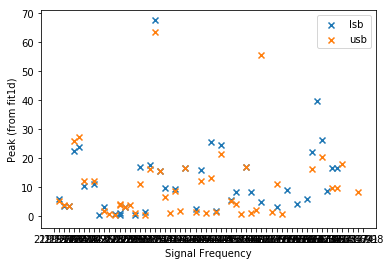

In [20]:
x = datamatched['finalfrqsig']
ylsb = datamatched['LSB_fit1dpeaks']
yusb = datamatched['USB_fit1dpeaks']

plt.scatter(x ,ylsb, marker='x',label='lsb')
plt.scatter(x ,yusb, marker='x',label='usb')

plt.xlabel('Signal Frequency')
plt.ylabel('Peak (from fit1d)')
plt.legend()

219.574 271.998


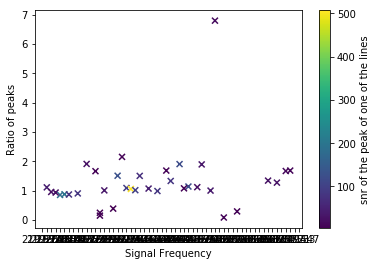

In [30]:
x = datamatched['finalfrqsig']
y = datamatched['ratios']

plt.scatter(x ,y, marker='x', c=datamatched['LSB_snr'],cmap='viridis')

plt.xlabel('Signal Frequency')
plt.ylabel('Ratio of peaks')
#plt.ylim((-1,3))
plt.colorbar(label='snr of the peak of one of the lines')
#plt.xlim(210.0,270.0)
#plt.xticks([215, 230, 245, 260, 285])
#print (np.arange(215, 272, 10.0))

print (min(x),max(x))
#print (x,y)

In [22]:
datamatched[55]

object,utdate,LSB_obsnum,LSB_lofreqe,LSB_obs_sb,LSB_mid_signal_band,LSB_mid_image_band,LSB_bwmode,LSB_nsubband,LSB_subbands,LSB_doppler,LSB_zsource,LSB_jcmtmedtsys,LSB_jcmttaust,LSB_jcmttauen,LSB_jcmtelstart,LSB_jcmtelend,LSB_jcmtamstart,LSB_jcmtamend,finalfrqsig,LSB_finalfrqimg,LSB_reducedpaths,LSB_reducedfiles,LSB_errors,LSB_fit1dpeaks,LSB_snr,LSB_fit1dfiles,USB_obsnum,USB_lofreqe,USB_obs_sb,USB_mid_signal_band,USB_mid_image_band,USB_bwmode,USB_nsubband,USB_subbands,USB_doppler,USB_zsource,USB_jcmtmedtsys,USB_jcmttaust,USB_jcmttauen,USB_jcmtelstart,USB_jcmtelend,USB_jcmtamstart,USB_jcmtamend,USB_finalfrqimg,USB_reducedpaths,USB_reducedfiles,USB_errors,USB_fit1dpeaks,USB_snr,USB_fit1dfiles,ratios
str9,int64,int64,float64,str3,float64,float64,str12,int64,str12,str5,float64,float64,float64,float64,float64,float64,float64,float64,str7,str7,str88,str31,float64,float64,float64,str37,int64,float64,str3,float64,float64,str12,int64,str12,str5,float64,float64,float64,float64,float64,float64,float64,float64,str7,str88,str31,float64,float64,float64,str37,float64
W3(OH),20161123,68,263.4966407352,LSB,259.04795517724915,267.9479215336704,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,1897.909057617,0.1946040391922,0.1938098222017,44.86019699871,44.78155171275,1.418005160561,1.420139305104,259.498,267.498,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworkingdrejy80y,ga20161123_68_1_reduced001.sdf,0.46157151460647583,8.456672668457031,18.321478689314215,ga20161123_68_1_reduced001_fit1d.sdf,69,255.4966374399,USB,259.9478815316173,251.04791632157674,1000MHzx2048,1,1000MHzx2048,radio,-0.000150081315057,1240.285644531,0.1917399317026,0.1925891488791,44.63638038797,44.55851457004,1.423607539012,1.425772652964,251.498,/export/data/hparsons/instrumentation/RxA3m/sideband-testing/reduced/ORACworking011d66fd,ga20161123_69_1_reduced001.sdf,0.3077605366706848,1.2433055639266968,4.03984727014263,ga20161123_69_1_reduced001_fit1d.sdf,6.8017653212687


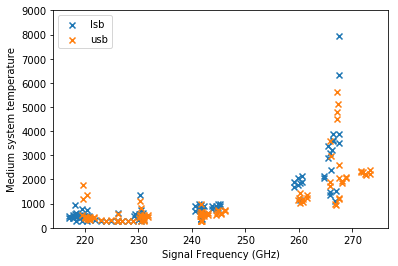

In [23]:
xlsb = lsb['mid_signal_band']
ylsb = lsb['jcmtmedtsys']

xusb = usb['mid_signal_band']
yusb = usb['jcmtmedtsys']

plt.scatter(xlsb ,ylsb, marker='x',label='lsb')
plt.scatter(xusb ,yusb, marker='x',label='usb')

plt.xlabel('Signal Frequency (GHz)')
plt.ylabel('Medium system temperature')
plt.ylim((0,9000))
plt.legend()

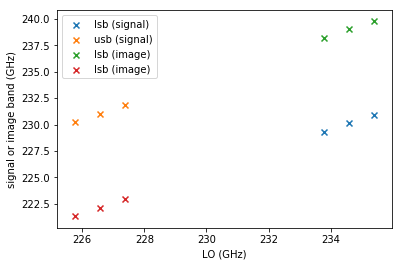

In [24]:
xlsb = lsb['lofreqe'][0:3]
y1lsb = lsb['mid_signal_band'][0:3]
y2lsb = lsb['mid_image_band'][0:3]

xusb = usb['lofreqe'][0:3]
y1usb = usb['mid_signal_band'][0:3]
y2usb = usb['mid_image_band'][0:3]

plt.scatter(xlsb,y1lsb,marker='x',label='lsb (signal)')
plt.scatter(xusb,y1usb,marker='x',label='usb (signal)')

plt.scatter(xlsb,y2lsb,marker='x',label='lsb (image)')
plt.scatter(xusb,y2usb,marker='x',label='lsb (image)')

plt.xlabel('LO (GHz)')
plt.ylabel('signal or image band (GHz)')
plt.legend()

# Matching rows

We need to compare same source with same frequncy on same night taken in upper and lower sidebands - ideally I would like to create a second table comprising of all the above data but for LSB and USB appended on the same line.

Remember need only data for wich both USB and LSB exist back to back. 

first I try and group by USB and LSB to then later match on

want to match to closes observation by ut date and observation number.

In [25]:
tdata_by_ob_ut_sb = tdata.group_by(['object', 'utdate', 'obs_sb']) 
print(tdata_by_ob_ut_sb.groups.keys)
print(tdata_by_ob_ut_sb.groups.indices)

  object   utdate  obs_sb
--------- -------- ------
    G34.3 20180402    LSB
    G34.3 20180402    USB
    G34.3 20180418    LSB
    G34.3 20180418    USB
IRC+10216 20180402    LSB
IRC+10216 20180402    USB
     OMC1 20161123    LSB
     OMC1 20161123    USB
   W3(OH) 20161123    LSB
   W3(OH) 20161123    USB
[  0  17  32  54  74  87  99 126 151 177 203]


In [26]:
g34_20180418_lsb = tdata_by_ob_ut_sb.groups[2]
g34_20180418_usb = tdata_by_ob_ut_sb.groups[3]

Text(0,0.5,'fit1dpeaks')

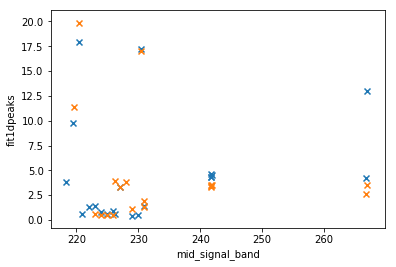

In [27]:
x_g34_20180418_lsb = g34_20180418_lsb['mid_signal_band']
y_g34_20180418_lsb = g34_20180418_lsb['fit1dpeaks']

x_g34_20180418_usb = g34_20180418_usb['mid_signal_band']
y_g34_20180418_usb = g34_20180418_usb['fit1dpeaks']

plt.scatter(x_g34_20180418_lsb ,y_g34_20180418_lsb, marker='x')
plt.scatter(x_g34_20180418_usb ,y_g34_20180418_usb, marker='x')

plt.xlabel('mid_signal_band')
plt.ylabel('fit1dpeaks')